## Importing libraries 

In [1]:
import os
import email
from email.policy import default
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import os
import re
import pandas as pd
from tqdm import tqdm
import random 
import numpy as np 
import re
import mailbox
from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix ,accuracy_score,\
precision_recall_fscore_support, classification_report 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


2024-08-05 19:57:25.682319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 19:57:25.682437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 19:57:25.847777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# checking for gpu 

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fea5f5ac-ad16-d0d2-9a95-c672959e6209)
GPU 1: Tesla T4 (UUID: GPU-22059ef5-d73e-fd7d-4982-eda4985ea65f)


In [3]:
# installing packages
!pip freeze > kaggle_image_requirements.txt
!pip install tensorflow-text


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


## Getting phishing and ham data

In [4]:

def extract_message_bodies(text):
    # Split the text by the pattern that typically indicates the start of a new email
    messages = re.split(r'From r\s+', text)
    
    # Define a pattern to match the email headers which are typically followed by a blank line
    header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)
    
    phishing_messages_1 = []
    
    for message in messages:
        if not message.strip():
            continue
        
        # Find the header and remove it to get the body
        header_match = header_pattern.match(message)
        if header_match:
            body = message[header_match.end():].strip()
        else:
            # If no header match is found, treat the whole message as the body
            body = message.strip()
        
        phishing_messages_1.append(body)
    
    return phishing_messages_1


with open('/kaggle/input/fraudulent-email-corpus/fradulent_emails.txt',encoding='latin1') as f : 
    text=f.read()
# Extract message bodies
phishing_messages_1 = extract_message_bodies(text)

# Print the message bodies to verify
# for idx, body in enumerate(message_bodies):
#     print(f"Message {idx + 1} Body:\n{body}\n{'-'*50}\n")


In [5]:
print(f'{len(phishing_messages_1)} messages were extracted from file fradulent_emails.txt')

3976 messages were extracted from file fradulent_emails.txt


In [6]:
print('random message extracted from fradulent_emails.txt : \n','#'*100)
random.choice(phishing_messages_1)

random message extracted from fradulent_emails.txt : 
 ####################################################################################################


'Steve Moore=28col=2E=29 \nOsnabrueck=2CGermany \nAttention Pls=2E=2C \nIN DESPERATE NEED OF YOUR CO-OPERATION! \nI write you this letter from Detention to solicit your help=2C as I am in dire need of your co-operation in this urgent matter=2E \nI am Steve Moore=2C a Colonel in The Coalition Army=28country detail will be given after introduction and proper establishment \nof trust=29 deployed to Iraq in the wake of the change of the Sadam Hussein Regime in Iraq=2E I served there until I was \narrested and detained in connection with the Iraqi prisoner abuse scandal in 2004=2E I was previously attached to a Military \nBase in Osnabrueck=2CGermany before my deployment to Iraq=2E I am presently at a detention facility in Osnabrueck=2CGermany=2E \nIn the course of my stay in Iraq=2CI have withnessed so much looting from which many colleagues have benefited in excess \nof some millions of Dollars=2E After a long hesitation=2C I decided to grab the opportunity that God had given me by placei

In [7]:
## getting ham data from email-spam-dataset-extended  dataset 

# Directory containing the email files
directory_ham = '/kaggle/input/email-spam-dataset-extended/ham_zipped/main_ham'

# List to store the message bodies
ham_messages = []

# Function to extract the body from an email message
def extract_body(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_ham):
    file_path = os.path.join(directory_ham, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body(msg)
    
    # Append the body to the list
    if body:
        ham_messages.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total ham messages extracted: {len(ham_messages)} from email-spam-dataset-extended/ham_zipped/main_ham')


Total ham messages extracted: 6947 from email-spam-dataset-extended/ham_zipped/main_ham


In [8]:
print('a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :\n','#'*100)
print(f'{random.choice(ham_messages)}')

a random message from ham messages extracted from email-spam-dataset-extended/ham_zipped/main_ham/ :
 ####################################################################################################
. . . or eventuality: Bush and Cheney fuck each other when the rest of the nation suddenly becomes unavailable.

http://www.hfcletter.com/letter/August02/

gg
http://xent.com/mailman/listinfo/fork





In [9]:

## getting phishing data from email-spam-dataset-extended 

# Directory containing the email files
directory_spam = '/kaggle/input/email-spam-dataset-extended/spam_zipped/main_spam'

# List to store the message bodies
phishing_messages_2 = []

# Function to extract the body from an email message
def extract_body_from_spam(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode(errors='replace')
    else:
        return msg.get_payload(decode=True).decode(errors='replace')

# Function to read file content in binary mode and decode it
def read_file_in_binary(file_path):
    with open(file_path, 'rb') as file:
        return file.read()

# Function to decode the binary content using different encodings
def decode_content(binary_content):
    encodings = ['utf-8', 'latin1', 'ascii']
    for enc in encodings:
        try:
            return binary_content.decode(enc)
        except UnicodeDecodeError:
            continue
    return binary_content.decode('latin1', errors='replace')  # fallback to 'latin1' with replacement

# Read all files in the directory
for filename in os.listdir(directory_spam):
    file_path = os.path.join(directory_spam, filename)
    
    # Read the file content in binary mode
    binary_content = read_file_in_binary(file_path)
    
    # Decode the binary content
    email_content = decode_content(binary_content)
    
    # Parse the email content
    msg = email.message_from_string(email_content, policy=default)
    
    # Extract the message body
    body = extract_body_from_spam(msg)
    
    # Append the body to the list
    if body:
        phishing_messages_2.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total phishing messages extracted {len(phishing_messages_2)} from email-spam-dataset-extended/spam_zipped/main_spam')


Total phishing messages extracted 2293 from email-spam-dataset-extended/spam_zipped/main_spam


In [10]:
print('a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:\n','#'*100)
print(f'{random.choice(phishing_messages_2)}') 

a random message from spam messages extracted from email-spam-dataset-extended/spam_zipped/main_spam/:
 ####################################################################################################
<html>

<head>
<meta http-equiv="Content-Language" content="en-us">
<meta name="GENERATOR" content="Microsoft FrontPage 5.0">
<meta name="ProgId" content="FrontPage.Editor.Document">
<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">
<title>Norton AD</title>
</head>

<body>

<table border="3" cellspacing="3" width="469" cellpadding="3" bgcolor="#000080"  bordercolor="#FFFFFF" style="border-collapse: collapse" bordercolordark="#FFFFFF">
  <tr>
    <td width="447">&nbsp;
      <table border="1" width="100%" bgcolor="#FFFFFF" bordercolor="#000080">
        <tr>
          <td width="100%" align="center"><font face="Impact" size="4" color="#CC0000">ATTENTION:
            This is a MUST for <u>ALL</u> Computer Users!!!</font></td>
        </tr>
      </table>
      <

In [11]:
## getting meassages from html like messages using beatiful soup 

def extract_message_body(message):
    soup = BeautifulSoup(message, 'html.parser')
    body = soup.get_text(separator='\n')
    return body.strip()

# List of messages
phishing_messages_3=[]
for ph_message in phishing_messages_2 : 
    phishing_messages_3.append(extract_message_body(ph_message))

In [12]:
print('a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:\n','#'*100)
print(f'{random.choice(phishing_messages_3)}')

a random phishing message from messages extracted from file in directory email-spam-dataset-extended/spam_zipped/main_spam:
 ####################################################################################################
NEWSLETTER COACH�INVEST � SEPTEMBRE 2002

Coach�Invest, l�accompagnateur des jeunes entreprises
www.coachinvest.com ou 3615 COACHINVEST (0.34 Euros/min)



DES NOUVELLES DE COACH�INVEST.

1- Lancement r�ussi pour Coach'Invest Interactive qui d�croche ses premiers contrats.

Coach'Invest Interactive accompagne les entreprises dans la cr�ation, le d�veloppement, l'optimisation et la gestion au quotidien de leur site Internet.
Coach'Invest Interactive propose � ses clients de nombreux services afin de les aider � concevoir et � mettre en place leur strat�gie Internet.
Contact : Hugo BEAULIEU ; T�l : 01 56 77 01 20 / 06 81 57 85 47; E-mail : webmaster@coachinvest.com 
Pour en savoir plus : http://www.coachinvest.com/entrepreneur/coach_interactive.html 



2- Coach'Inv

In [13]:
## getting data from phishingemaildetection dataset 

# Path to the mbox file
legal_emails_file = '/kaggle/input/phishingemaildetection/emails-enron-legal-mails.mbox'

# List to store the message bodies
legal_emils = []

# Function to extract the body from an email message
def extract_body_from_legal(msg):
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))

            # Skip attachments and just get the plain text part
            if "attachment" not in content_disposition:
                if content_type == "text/plain":
                    return part.get_payload(decode=True).decode('utf-8', errors='replace')
    else:
        return msg.get_payload(decode=True).decode('utf-8', errors='replace')

# Open the mbox file
mbox = mailbox.mbox(legal_emails_file)

# Iterate through each message in the mbox file
for msg in mbox:
    # Extract the message body
    body = extract_body_from_legal(msg)
    
    # Append the body to the list
    if body:
        legal_emils.append(body)

# Now message_bodies contains all the email message bodies
print(f'Total benign messages extracted from  emails-enron-legal-mails.mbox : {len(legal_emils)} message')



Total benign messages extracted from  emails-enron-legal-mails.mbox : 4279 message


In [14]:
# let's have a look on legal messages extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:\n','-'*100)
for message in random.sample(legal_emils,2): 
    print(message,'\n\n\n','#'*100)


A random sample of benign messages exracted from  emails-enron-legal-mails.mbox:
 ----------------------------------------------------------------------------------------------------
Because of my meeting schedule, it would be particularly helpful if this were 
videotaped, so I could be sure to be able to attend.
---------------------- Forwarded by Mary Hain/HOU/ECT on 03/01/2001 12:49 PM 
---------------------------
To: Fran Chang/PDX/ECT@ECT, Ryan Slinger/PDX/ECT@ECT, Maria Van 
Houten/PDX/ECT@ECT, Chris Stokley/HOU/ECT@ECT, Donna Johnson/PDX/ECT@ECT, 
David Poston/PDX/ECT@ECT, Kate Symes/PDX/ECT@ECT, Cara Semperger/PDX/ECT@ECT, 
Mary Hain/HOU/ECT@ECT, Mark Guzman/PDX/ECT@ECT, Robert Anderson/PDX/ECT@ECT, 
Andy Chen/PDX/ECT@ECT, Chris Lackey/PDX/ECT@ECT, Crystal Hyde/PDX/ECT@ECT
cc: Christopher F Calger/PDX/ECT@ECT, Tim Heizenrader/PDX/ECT@ECT, Jeff 
Richter/HOU/ECT@ECT, Murray P O'Neil/HOU/ECT@ECT, Valarie Sabo/PDX/ECT@ECT, 
Steve Nat/Corp/Enron, Bill Williams III/PDX/ECT@ECT, Amy F

In [15]:
## cleaning legal_eamils list to get message bodies 

def clean_legal_email_body(email):
    # Remove forwarded or replied metadata
    email = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email, flags=re.IGNORECASE)
    # Remove email headers (To, From, Cc, etc.)
    email = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email, flags=re.IGNORECASE)
    # Remove metadata that appears after the body
    email = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email, flags=re.IGNORECASE)
    # Remove leading and trailing whitespace
    email = email.strip()
    return email

def extract_and_clean_legal_emails(email_list):
    cleaned_bodies = []
    for email in email_list:
        cleaned_body = clean_legal_email_body(email)
        cleaned_bodies.append(cleaned_body)
    return cleaned_bodies

# creating a list of cleaned messages 
legal_emils_cleaned=extract_and_clean_legal_emails(legal_emils)

 > ##### legal_emils_cleaned is the final version of cleaned emails gotten from phishingemaildetection/emails-enron-legal-mails.mbox
 


In [16]:
# lets have a look on sample of cleaned legal emails extracted from emails-enron-legal-mails.mbox
print('A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :\n','-'*100)

for m in random.sample(legal_emils_cleaned,2): 
    print(m,'\n\n','#'*100)

A random sample of benign messages exracted from  emails-enron-legal-mails.mbox after cleaning :
 ----------------------------------------------------------------------------------------------------
"Ditto Credit" - or in other words,  no change to the physical power profiles 
for these CP's if they are currently trading on EOL. If they are not 
currently trading on EOL, then they are not approved for physical power.  

Thanks, 

Shari




	Tana Jones
	01/31/2001 09:50 AM
		 
		 To: Alan Aronowitz/HOU/ECT@ECT, Jeffrey T Hodge/HOU/ECT@ECT, Shari 
Stack/HOU/ECT@ECT, Harry M Collins/HOU/ECT@ECT, David 
Minns/ENRON_DEVELOPMENT@ENRON_DEVELOPMENt, Marie Heard/Enron 
Communications@Enron Communications, Robbi Rossi/Enron Communications@Enron 
Communications, John Viverito/Corp/Enron@Enron, Jane McBride/AP/Enron@Enron, 
Andrea Calo/SA/Enron@Enron, Peter Keohane/CAL/ECT@ECT
		 cc: 
		 Subject: EOL Approvals, 1-31-01




	Walter Guidroz@ENRON
	01/31/2001 09:42 AM
		 
		 To: Karen Lambert/HOU/ECT

### Getting phishing emails from  emails-phishing-nazario.mbox

In [17]:

# Path to the mbox file
phishing_nazario_file_path = "/kaggle/input/phishingemaildetection/emails-phishing-nazario.mbox"

# Function to extract messages from mbox file
def extract_messages_from_mbox(mbox_file_path):
    messages = []
    mbox = mailbox.mbox(mbox_file_path)
    for message in mbox:
        messages.append(message)
    return messages

# Extract messages from mbox file
phishing_nazario_messages = extract_messages_from_mbox(phishing_nazario_file_path)

# Print the number of extracted messages
print(f"Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: {len(phishing_nazario_messages)} message")




Number of phishing messages extracted from file phishingemaildetection/emails-phishing-nazario.mbox: 2279 message


In [18]:
## removing messages that causes Unicodeerror 
import traceback
def clean_messages(messages):
    cleaned_messages = []
    for message in messages:
        try:
            # Attempt to decode and encode message to handle Unicode characters
            message_str = message.as_string()
            message_str.encode('utf-8')
            cleaned_messages.append(message)
        except UnicodeEncodeError:
            # If UnicodeEncodeError occurs, skip the message
#             traceback.print_exc()  # Print traceback to debug the error
            continue
    return cleaned_messages

# Clean the phishing_nazario_messages list
cleaned_phishing_nazario_messages = clean_messages(phishing_nazario_messages)
print(f'removed {len(phishing_nazario_messages)-len(cleaned_phishing_nazario_messages)} messages that cause Unicodeerror')


removed 141 messages that cause Unicodeerror


In [19]:
print(f'{len(cleaned_phishing_nazario_messages)} phishing messages remains after removing message that cause Unicodeerror' )

2138 phishing messages remains after removing message that cause Unicodeerror


In [20]:
# let's have a look on sample of cleaned_phishing_nazario_messages
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after removing message that cause Unicodeerror :\n','-'*100)

for m in random.sample(cleaned_phishing_nazario_messages,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after removing message that cause Unicodeerror :
 ----------------------------------------------------------------------------------------------------
Return-Path: <user@mail.example.com>
Delivered-To: user@example.com
Received: from mail.example.com (mail.example.com [192.168.6.4])
	by example.com (Postfix) with ESMTP id E14082A89A
	for <user@example.com>; Tue, 21 Feb 2006 18:25:21 -0500 (EST)
Received: by mail.example.com (Example mail relay)
	id D0418621C9C; Tue, 21 Feb 2006 18:25:21 -0500 (EST)
Delivered-To: user@example.com
Received: from mail.example.com (mail.example.com [192.168.3.6])
	by mail.example.com (Example mail relay) with ESMTP id AF527621C95
	for <user@example.com>; Tue, 21 Feb 2006 18:25:21 -0500 (EST)
Received: (from user@localhost)
	by mail.example.com id SAA17769
	for user@example.com; Tue, 21 Feb 2006 18:25:21 -0500
Received: from mail.tecnicasangiorgio.it

> ##### cleaned_phishing_nazario_messages is like html so we have to get text from it 

In [21]:
# getting text from html for cleaned_phishing_nazario_messages
def extract_phishing_text_from_html(html_content):
    # Convert bytes-like object to string if necessary
    if isinstance(html_content, bytes):
        html_content = html_content.decode('utf-8')
    
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n')
    # Remove the long, seemingly random text at the end
    if '*******' in text:
        text = text.split('*******')[0]
    return text

def extract_text_from_payload(payload):
    if isinstance(payload, str):
        return payload
    elif isinstance(payload, bytes):
        return payload.decode('utf-8')
    elif isinstance(payload, list):
        text = ''
        for part in payload:
            text += extract_text_from_payload(part)
        return text
    elif isinstance(payload, email.message.Message):
        return extract_text_from_payload(payload.get_payload())
    else:
        return ''

# Extract text from HTML content
cleaned_phishing_nazario_messages_text = []
for message in cleaned_phishing_nazario_messages:
    if isinstance(message, email.message.Message):
        html_content = extract_text_from_payload(message)
        if html_content:
            extracted_text = extract_phishing_text_from_html(html_content)
            cleaned_phishing_nazario_messages_text.append(extracted_text)



In [22]:
# let's have a look on sample of cleaned_phishing_nazario_messages_text 
print('A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox \
after extracting messages from html format and cleaning message body :\n','='*100)

for m in random.sample(cleaned_phishing_nazario_messages_text,1):
    print(m,'\n\n')

A random sample of phishing messages exracted from  file phishingemaildetection/emails-phishing-nazario.mbox after extracting messages from html format and cleaning message body :










R0lGODlhPAJIAfOuAAQGAIAAAMDAwMDcwIAAQIAgQKBAQKBggICAgMCAgMCgwOCgwP/78AAA/////wAA
ACH5BAQAAAAALAAAAAA4AkYBAAT/0MlJq7046827/2AojmRpnmiqrmzrvnCMFXRt33iu73zv/8CgcEgs
Go/IpHLJbDqf0Kh0epNQr9isdsvter/gsFhsHZvP6LR6zW670eW3fE6v2+/4fDCu7/v/gIGCgzl8hIeI
iYqLjEmGRwGRkpEGBZI3k5M0kT4KDAwLlTYHBqWmp6ilB42sra6vbI9EHQwKlgUCHLU7CRYLNQcjq7DE
xcbHTbJEAcEUBwcKFQyWAQUVCgYHDBTTN80SDAMStgUG4KSVFejaEqLI7/Dx8tYOyRTUBLkUBJEVCQH8
vvEJwI2TAwbVzHXbVOGWpQUO3M2bSLHiIWXLKhggwJFAhQX9/yj8K8BP3AQBNcxN+BdpW8KINghSkGht
mMWbOHMuKbXJJhOMQ2RO2LgpGoWQKwnQICCwHg2VEyRJqBasWg2h7W4w8Kmzq9evOMwJSMCg1xOgQrBG
VGqp11G1CdgSgJqVhjpmDoYFw6TxRgKaYAMryvaMK5JsaQgb7kGKxrMjtch+OutUiVqiJN1GhSu3qTt9
E4ItzHFZsGlYoCcMWCwkF2su7CaUBRIMJT0jBnr9DTB6Cdogl9kGSI0QrtUAEO+ltNAbR+nT0BvlYiCg
+ra8SFyPMTo2gdEBP2rbrUwkweMCCSgzCc6P3lCkEv619xczdT2rOp5H348oV/oa0TSXR/8zPhmwDTk8


In [23]:
## removing long bad text that is longer than 25 words 
def remove_long_words(messages):
    cleaned_messages = []
    for message in messages:
        words = message.split()
        cleaned_words = [word for word in words if len(word) <= 25]
        cleaned_message = ' '.join(cleaned_words)
        cleaned_messages.append(cleaned_message)
    return cleaned_messages


cleaned_phishing_nazario_messages_text_1 = remove_long_words(cleaned_phishing_nazario_messages_text)



In [24]:
# to find if the long text was removed or not 
cleaned_phishing_nazario_messages_text_1[:5]

['in 1841 stars battle Tour de France in 1872 in 1923',
 'Dear eBay User , After fraud complaints from the eBay members, the eBay Inc. had developed a security program against the fraudulend attempts of accounts thefts. For that we have to securise all the members informations by updating and checking the registrated informations. Please update your information by completing the form from the forwarded link so we can check your account validity and your identity and login to eBay in order to update your informations. This process will take 5 days, period when you will not be able to acces your eBay account. After this period you will receive instructions to enter and securise your eBay account.Please click the link below and sign in into your account: -- As outlined in our User Agreement, eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you have any questions. Regards,Safeharbor Department eBay, Inc.',
 "Dea

## Getting all data into a dataframe 

In [25]:
## making a dataframe from ham messages 
all_ham_messages=ham_messages+legal_emils_cleaned#+ham_messages_2100
ham_df=pd.DataFrame({'phishing':[0]*len(all_ham_messages),'text':all_ham_messages})
ham_df

,phishing,text
0,0,\nme:\n> >Spam is *the* tool for dissident new...
1,0,Chuck Murcko wrote:\n> > The usual crud. Why ...
2,0,<html><head><!--\n\n CLICK HERE to read t...
3,0,"On Wednesday 31 July 2002 12:02, Satelle, Stev..."
4,0,URL: http://scriptingnews.userland.com/backiss...
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [26]:
## making a dataframe from phishing data
all_phishing_data=phishing_messages_1+phishing_messages_3+cleaned_phishing_nazario_messages_text_1
phishing_df=pd.DataFrame({'phishing':[1]*len(all_phishing_data),'text':all_phishing_data})
phishing_df

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
8380,1,"Dear PayPal Member, Your account has been rand..."
8381,1,Web-Based Email :: View :: eBay sent this mess...
8382,1,"Dear eBay user, eBay Customer Support Team req..."
8383,1,"Dear PayPal Member, Your account has been rand..."


In [27]:
## concatinating ham and phishing into a dataframe 
data=pd.concat([phishing_df,ham_df],axis=0)
data

,phishing,text
0,1,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1,1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ..."
2,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3,1,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4,1,"Dear sir, \n \nIt is with a heart full of hope..."
...,...,...
11221,0,Fly me to the moon.
11222,0,Here is order:\r\n\r\nhttp://cips.ferc.fed.us/...
11223,0,This is really good.\r\n\r\n------------------...
11224,0,That actually made me cry.\r\n\r\nSusan


In [28]:
# shuffling data to ensure that the splits are representative of the whole dataset.
shuffled_df=data.sample(frac=1,random_state=42)
shuffled_df

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,"Dear eBay member, Congratulations! Your recent..."
...,...,...
2899,0,"URL: http://www.newsisfree.com/click/-4,826803..."
3579,0,"URL: http://www.newsisfree.com/click/-0,859765..."
5390,1,Direct Email \nBlaster\n \n\n\nThe program wil...
860,1,FROM:TSEPO VUSI\n\nEMAIL_tsepovusi@netscape.ne...


In [29]:
## checking for balance of data 
shuffled_df['phishing'].value_counts()

phishing
0    11226
1     8385
Name: count, dtype: int64

In [30]:
shuffled_df.isna().sum()

phishing    0
text        0
dtype: int64

In [31]:
## checking for duplicates 
shuffled_df.duplicated().sum()

4594

In [32]:
## duplicates in phishing class 
duplicated_phishing=shuffled_df[shuffled_df['phishing']==1].duplicated().sum()
print(f'there is {duplicated_phishing} duplicated phishing messages in data ')

there is 1913 duplicated phishing messages in data 


In [33]:
## number of duplicates in non-phishing  class 

duplicated_ham=shuffled_df[shuffled_df['phishing']==0].duplicated().sum()
print(f'there is {duplicated_ham} duplicated ham messages in data ')

there is 2681 duplicated ham messages in data 


In [34]:
## removing duplicates 
shuffled_df=shuffled_df.drop_duplicates()


In [35]:
# counting classes in data after remvoing duplicates 

num_phishing_messages=len(shuffled_df[shuffled_df['phishing']==1])
num_ham_messages=len(shuffled_df[shuffled_df['phishing']==0])
print(f'there is {num_phishing_messages} phishing messages and {num_ham_messages} ham messages in data after removing Duplicates')

there is 6472 phishing messages and 8545 ham messages in data after removing Duplicates


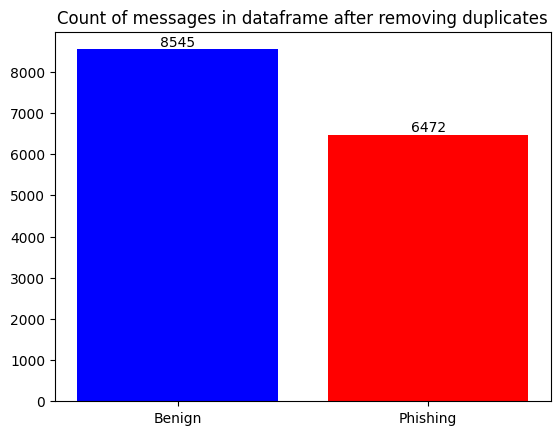

In [36]:
import matplotlib.pyplot as plt

counts = shuffled_df['phishing'].value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of messages in dataframe after removing duplicates')

# Display the plot
plt.show()


In [37]:
# saving extracted data to csv file 
shuffled_df.to_csv('extracted_data.csv', index=False, escapechar='\\')


## splitting data to train and test 


In [38]:
shuffled_df
## for column phishing  1 means phishing and 0 means legitimate (legal or ham) messages 

,phishing,text
8442,0,Daily Blessing\r\nhttp://www.daily-blessings.c...
7863,0,"Hey there,\r\nThanks for the pics. What a cut..."
7109,1,- U.S. Bank Update Report - In attention of U....
3971,1,"Atten: My Dear ,\n \nI have Paid the fee for y..."
7672,1,"Dear eBay member, Congratulations! Your recent..."
...,...,...
6038,0,<html><head><!--\n\n\n CLICK HERE to read...
4426,1,Do you take credit cards?\n\n\nIf you do you w...
8465,0,"Juan,\r\n\r\nI did not go to Fidelity. It was..."
6265,1,Hello Unlimited International Telephone Call M...


In [39]:
# splitting data into 80% train and 20% test data 
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(shuffled_df['text'],
                                                               shuffled_df['phishing'],
                                                               random_state=42,test_size=.2)

In [40]:
# counting classes in train data to check for balance 
train_labels.value_counts()

phishing
0    6783
1    5230
Name: count, dtype: int64

In [41]:
print(f'total messages in trian data are {len(train_labels)} message')


total messages in trian data are 12013 message


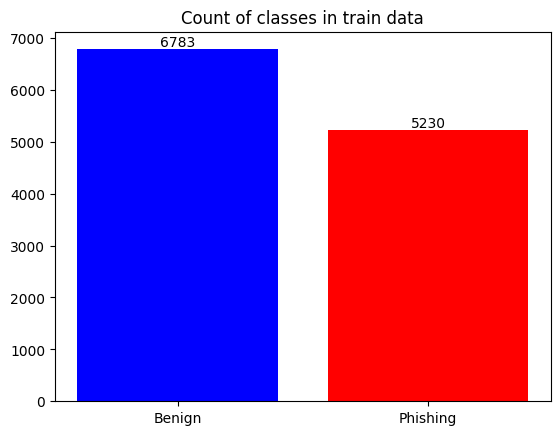

In [42]:
train_counts = train_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, train_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in train data')

# Display the plot
plt.show()


In [43]:
print(f'total messages in test data are {len(test_labels)} message')


total messages in test data are 3004 message


In [44]:
# counting classes in test data to check for balance 

print(test_labels.value_counts())


phishing
0    1762
1    1242
Name: count, dtype: int64


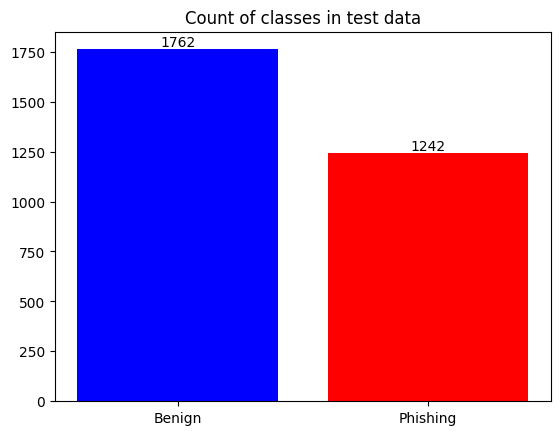

In [45]:
test_counts = test_labels.value_counts().values
categories = ['Benign', 'Phishing']

# Create the bar plot
plt.bar(categories, test_counts, color=['blue', 'red'])

# Add text above the bars
for i, count in enumerate(test_counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

# Set the title of the plot
plt.title('Count of classes in test data')

# Display the plot
plt.show()


In [46]:
## defining a function for calculating metrics 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) 
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [47]:
## lets have a look at messages length (number of words in each message)
messages_length=[]
# find length of every message 
for index,label,message in shuffled_df.itertuples() : 
    messages_length.append(len(message.split(' ')))
random.sample(messages_length,25)    
    

[161,
 252,
 197,
 235,
 1266,
 246,
 448,
 43,
 308,
 101,
 2,
 77,
 167,
 61,
 260,
 8,
 683,
 191,
 204,
 115,
 180,
 31,
 12,
 319,
 315]

In [48]:
print(f'longest message in data  has {max(messages_length)} words')
# finding what value that 95% of lengths of messages are below it 
l=round(np.percentile(messages_length,95))
print(f'length of 95% of messages is less than {l} words')

longest message in data  has 36351 words
length of 95% of messages is less than 1080 words


 >* as length of 95% of messages is less than 1081 words  we can take output_sequence_length as 1024 or 512 so our model is going to see only first 1024 words of every message  
 >* we will take  max_tokens=20000 so our model is going to take most frequent 20000 words 

In [49]:
## making Text vectorization layer 
from keras import layers  
text_vectorizer=layers.TextVectorization(max_tokens=20000,output_mode='int',output_sequence_length=1024,name='text_vectorization')

In [50]:
# adapting text vectorizer on train data 
text_vectorizer.adapt(train_text)

In [51]:
# getting a list of words in the train data 
words_in_vocab=text_vectorizer.get_vocabulary()

In [52]:
print('most common 20 words are : \n')
words_in_vocab[:20]

most common 20 words are : 



['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'in',
 'you',
 'i',
 'for',
 'this',
 'is',
 'your',
 'that',
 'will',
 'as',
 'on',
 'with',
 'be']

In [53]:
print('most uncommon 20 words are : \n')
words_in_vocab[-20:]
## we are going to keep numbers in data as For tasks like spam detection, numbers could be significant.
# For example, spam messages often contain phone numbers, prices, or promotional codes.

most uncommon 20 words are : 



['finalizing',
 'fighters',
 'fifteenmillion',
 'fibroid',
 'ff',
 'fetching',
 'ferrostall',
 'fernandez',
 'fel',
 'feast',
 'fcalgerenroncom',
 'façon',
 'favouring',
 'faulty',
 'fatigue',
 'fastow',
 'fastcheck',
 'fantasia',
 'famers',
 'faites']

In [54]:
# testing text vectorizer for a sentence 
sentence='i am happy today . i am going to have a vacancy . '
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 1024), dtype=int64, numpy=array([[   9,   41, 1133, ...,    0,    0,    0]])>

### Creating an Embedding using an Embedding Layer


In [55]:
# creating an embedding layer with sequence length 1024  words and  sees most common 200000 words 
embed=layers.Embedding(input_dim=20000,output_dim=128,input_length=1024,name='Embedding_Name-123')

In [56]:
# testing embedding layer for a sentence 
embed(text_vectorizer([sentence]))

<tf.Tensor: shape=(1, 1024, 128), dtype=float32, numpy=
array([[[-0.00455378, -0.03835496,  0.03767176, ...,  0.01840189,
          0.02831027, -0.00894688],
        [-0.01008817,  0.0463467 , -0.02956072, ..., -0.00552728,
         -0.02853783, -0.00948274],
        [ 0.02843228, -0.00972433, -0.01785872, ..., -0.04272193,
         -0.04519799,  0.00680061],
        ...,
        [-0.00887593,  0.01071596, -0.02146271, ...,  0.04321   ,
          0.01027609, -0.00927012],
        [-0.00887593,  0.01071596, -0.02146271, ...,  0.04321   ,
          0.01027609, -0.00927012],
        [-0.00887593,  0.01071596, -0.02146271, ...,  0.04321   ,
          0.01027609, -0.00927012]]], dtype=float32)>

## Satrting Experiments 

In [57]:
## creating functions for callbacks 

# function to create a checkpoint callback 
def create_checkpoint_callback(file_path):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,  # Path to save the model
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_best_only=True,  # Set to True to save only the best model based on a monitored metric
    monitor='val_loss',  # Metric to monitor
    mode='auto',  # Mode for monitoring the metric (auto, min, max)
    save_freq='epoch'  # Frequency to save the model ('epoch' or integer steps)
    )
    return model_checkpoint_callback
# function to create a tensorboard callback 
def create_tensorboard_callback(file_path):
    tensorboard=tf.keras.callbacks.TensorBoard(log_dir=file_path)
    return    tensorboard
    

## Long-Term Short Memory (LSTM) model  

In [58]:
import tensorflow as tf 
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed(x)
x=layers.LSTM(64,activation='tanh',name='lstm_layer',return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
lstm_model_1=tf.keras.Model(inputs,outputs,name='lstm_model_1')
lstm_model_1.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

#### creating tensorboard , early stopping and checkpoint callpacks 

In [59]:
lstm_1_checkpoint_callback = create_checkpoint_callback(file_path='checkpoints/lstm_1_checkpoint.keras')

lstm_tensorboard=create_tensorboard_callback(file_path='logs/lstm_1')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    mode='max',  # Mode for monitoring the metric ('min', 'max', or 'auto')
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [60]:
# training lstm_model_1 
lstm_1_history = lstm_model_1.fit(train_text,train_labels, epochs=50, validation_data=(test_text, test_labels),
                                   callbacks=[lstm_1_checkpoint_callback, lstm_tensorboard, early_stopping_callback])


Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7862 - loss: 0.4678 - val_accuracy: 0.9249 - val_loss: 0.2600
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9365 - loss: 0.2162 - val_accuracy: 0.9553 - val_loss: 0.1717
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9743 - loss: 0.1088 - val_accuracy: 0.9606 - val_loss: 0.1568
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9780 - loss: 0.0991 - val_accuracy: 0.9723 - val_loss: 0.1233
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9881 - loss: 0.0585 - val_accuracy: 0.9589 - val_loss: 0.1453
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9658 - loss: 0.1023 - val_accuracy: 0.9749 - val_loss: 0.1014
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9860 - loss: 0.0524 - val_accuracy: 0.9818 - val_loss: 0.0689
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9961 - loss: 0.0129 - 

In [61]:

lstm_model_1.summary()

Model: "lstm_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Name-123 (Embedding)  │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 1024, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,834,565 (29.89 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,223,044 (19.92 MB)

In [62]:
# craeting function to plot training curves 
def plot_loss_and_accuracy_curves(model_history):
    epochs = range(len(model_history.history['loss']))
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


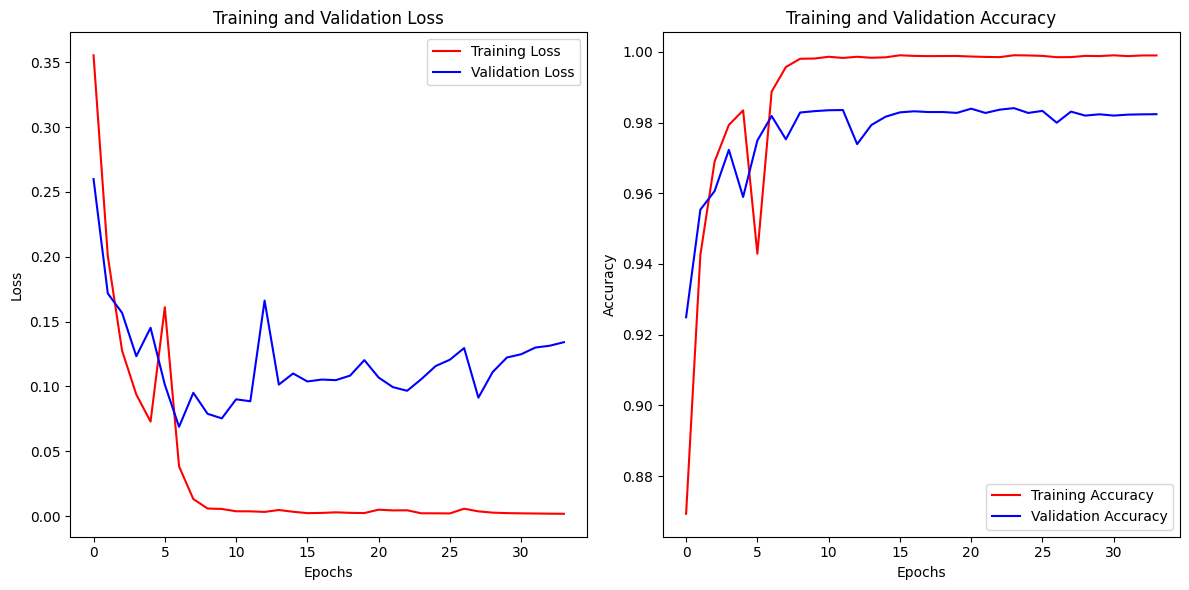

In [63]:
# plotting training curves for lsmt_model_1

plot_loss_and_accuracy_curves(lstm_1_history)

### Evaluating lstm_model_1

In [64]:
## calculating metrics for model 
pred_labels_lstm1=lstm_model_1.predict(test_text)
pred_labels_lstm1.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


(3004, 1024, 1)

In [65]:
import seaborn as sns
# creating function to plot confusion matrix 
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: list = ["ham", "Phishing"]) -> None:
    """
    Plots a confusion matrix for binary classification.

    Parameters:
    y_true (np.ndarray): Ground truth (correct) target values.
    y_pred (np.ndarray): Estimated targets as returned by a classifier.
    class_names (list): List of class names. Default is ["Negative", "Positive"].
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [66]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# function to calculate other important metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate various classification metrics using scikit-learn.

    Args:
        y_true (list or np.array): The true labels.
        y_pred (list or np.array): The predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.

    Note:
        - The function assumes binary classification (0 and 1 labels).
        - The true labels and predicted labels should be of the same length.
    """
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate metrics
    FDR = fp / (tp + fp) if (tp + fp) != 0 else 0  # False Discovery Rate
    FNR = fn / (tp + fn) if (tp + fn) != 0 else 0  # False Negative Rate
    FOR = fn / (fn + tn) if (fn + tn) != 0 else 0  # False Omission Rate
    FPR = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate
    NPV = tn / (tn + fn) if (tn + fn) != 0 else 0  # Negative Prediction Value
    

    metrics = {
        'False Discovery Rate (FDR)': FDR,
        'False Negative Rate (FNR)': FNR ,
        'False Omission Rate (FOR)': FOR,
        'False Positive Rate (FPR)': FPR,
        'Negative Prediction Value (NPV)': NPV
        
    }

    return metrics

In [67]:
# Average over the time steps
avg_pred_labels_lstm1 = np.mean(pred_labels_lstm1, axis=1)

avg_pred_labels_lstm1.flatten().shape
avg_pred_labels_lstm1=np.round(avg_pred_labels_lstm1.flatten())

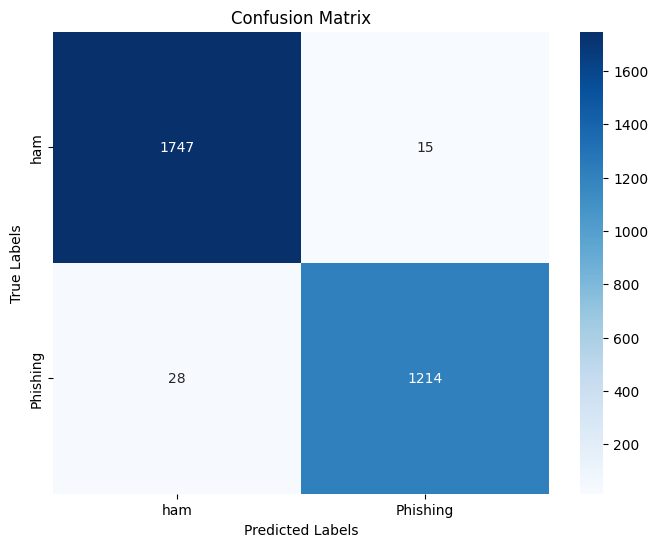

In [68]:
plot_confusion_matrix(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)

In [69]:
# calculating metrics for lstm_model_1
lstm_model_1_results=calculate_results(y_pred=avg_pred_labels_lstm1,y_true=test_labels.values)
print('metrics for lstm_model_1\n')

for key , value in lstm_model_1_results.items() : 
    print(key,value,'\n')

metrics for lstm_model_1

accuracy 0.9856857523302264 

precision 0.985701200013569 

recall 0.9856857523302264 

f1 0.9856744040178087 



In [70]:
# classification report of model lstm_model_1 

report_1=classification_report(test_labels.values,avg_pred_labels_lstm1)
print(f"classification report for lstm_model_1 \n\n {report_1}")

classification report for lstm_model_1 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1762
           1       0.99      0.98      0.98      1242

    accuracy                           0.99      3004
   macro avg       0.99      0.98      0.99      3004
weighted avg       0.99      0.99      0.99      3004



In [71]:
# calculating other metrices for lstm_model_1
print('other metrics for lstm_model_1\n')

for key , value in calculate_metrics(test_labels.values,avg_pred_labels_lstm1).items():
    print(key,value,'\n')

other metrics for lstm_model_1

False Discovery Rate (FDR) 0.012205044751830757 

False Negative Rate (FNR) 0.02254428341384863 

False Omission Rate (FOR) 0.015774647887323943 

False Positive Rate (FPR) 0.00851305334846765 

Negative Prediction Value (NPV) 0.984225352112676 



### creating a projector
#### we are going to create a projector to visualize our words as model lstm_model_1  sees it 

In [72]:
# to get a list of layers in lstm_model_1 
lstm_model_1.layers

[<InputLayer name=input_layer, built=True>,
 <TextVectorization name=text_vectorization, built=True>,
 <Embedding name=Embedding_Name-123, built=True>,
 <LSTM name=lstm_layer, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [73]:
# storing weights of embedding layer in variable embedding_weights 
embedding_weights=lstm_model_1.get_layer('Embedding_Name-123').get_weights()[0]
print(embedding_weights,'\n\n')

print('Shape of embedding weights',embedding_weights.shape)


[[-2.19185901e+00  2.47325826e+00  2.26705647e+00 ... -2.04578447e+00
  -2.44981575e+00 -2.19320416e+00]
 [ 2.84325071e-02  2.23557562e-01 -1.23186015e-01 ... -5.29666655e-02
   6.48675263e-02  2.61100437e-02]
 [-9.76198465e-02  6.42276704e-02  9.29265022e-02 ...  3.58271338e-02
  -6.94270208e-02 -2.43893489e-01]
 ...
 [ 3.25714471e-03  6.20945357e-03 -6.27156487e-03 ...  5.31287715e-02
  -4.77952464e-03  3.21782082e-02]
 [ 1.30000105e-02 -4.67890948e-02 -7.10925180e-03 ... -1.12551190e-02
   2.74577702e-04 -1.79361776e-02]
 [-3.09000127e-02  2.28864923e-02 -5.67654483e-02 ...  1.17383087e-02
   4.16914746e-02 -2.31454484e-02]] 


Shape of embedding weights (20000, 128)


> ##### to visualize words on a projector download files embedding_vectors.tsv and embedding_metadata.tsv on your pc 
> ##### open this link https://projector.tensorflow.org/  and upload two files .You will see a projector of data words.   

In [74]:
## saving words and weights to use in tsv files to download them, then uploading two files localy to visualize words   
# Create output writers
import io

out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embedding_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()


<!-- we'll be building the following:
* **Model 1**: Long-Term Short Memory (LSTM)
* **Model 2**: 1D Convolutional Neural Networks (CNNs)
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
 -->

## Convolutional Neural Network (CNN) model

In [88]:
from keras import regularizers


# Assuming you have defined `text_vectorizer` and trained it
# Preprocess the training text data using the text vectorizer
processed_train_text = text_vectorizer(train_text)

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(processed_train_text.shape[1],), dtype="float32")
x = layers.Embedding(input_dim=processed_train_text.shape[1], output_dim=128)(inputs)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu",  
                  kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.L2(1e-4),
                  activity_regularizer=regularizers.L2(1e-5))(x)

x = layers.Dropout(0.2)(x)  # Adding dropout layer with dropout rate of 0.2
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu",  
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5))(x) 
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = tf.keras.Model(inputs, outputs, name="Conv1D_model")

# Compile Conv1D model
cnn_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the 1D convolution model
cnn_model.summary()

Model: "Conv1D_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1024, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1020, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1020, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,761 (600.63 KB)

 Trainable params: 153,761 (600.63 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
## defining callbacks for cnn model 
cnn_model_checkpoint_callback =create_checkpoint_callback(file_path='checkpoints/cnn_checkpoint.keras')
cnn_model_tensorboard=create_tensorboard_callback(file_path='logs/cnn')


In [91]:
# fitting cnn model 
cnn_history=cnn_model.fit(processed_train_text,train_labels,validation_split=.2,epochs=20,
            callbacks=[cnn_model_tensorboard,early_stopping_callback,cnn_model_checkpoint_callback])

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9789 - loss: 0.1021 - val_accuracy: 0.9800 - val_loss: 0.0891
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9864 - loss: 0.0775 - val_accuracy: 0.9779 - val_loss: 0.0901
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9901 - loss: 0.0637 - val_accuracy: 0.9784 - val_loss: 0.0852
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9909 - loss: 0.0597 - val_accuracy: 0.9763 - val_loss: 0.0868
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9933 - loss: 0.0514 - val_accuracy: 0.9784 - val_loss: 0.0859
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9933 - loss: 0.0473 - val_accuracy: 0.9767 - val_loss: 0.0848
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9957 - loss: 0.0416 - val_accuracy: 0.9759 - val_loss: 0.0889
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9937 - loss: 0.0445 - val_accuracy: 0

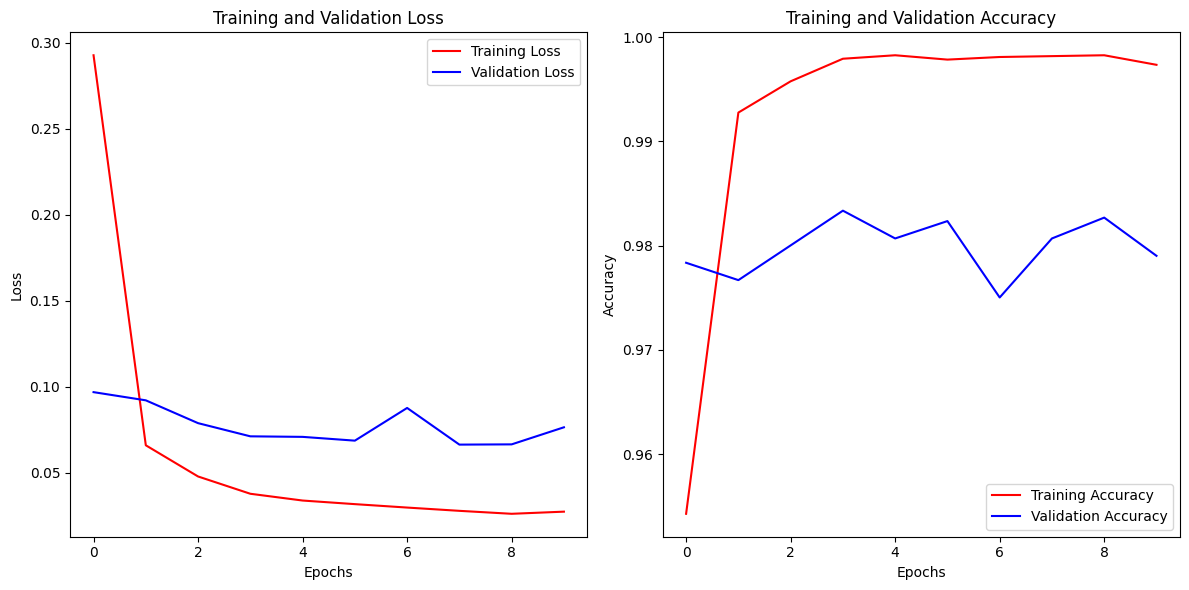

In [78]:
# plotting training curves for cnn model 



plot_loss_and_accuracy_curves(cnn_history)


### Evaluating CNN model

In [79]:
pred_labels_cnn=cnn_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_cnn = np.mean(pred_labels_cnn, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_cnn=np.round(avg_pred_labels_cnn.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


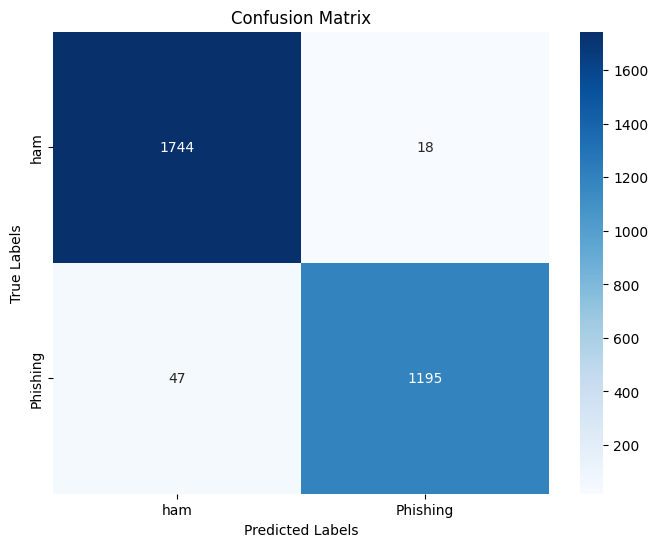

In [80]:
plot_confusion_matrix(y_pred=avg_pred_labels_cnn,y_true=test_labels.values)

In [81]:
# calcualting metrics for cnn model 
cnn_results=calculate_results(avg_pred_labels_cnn,test_labels.values)
print(f'metrics for cnn model are \n\n {cnn_results}')

metrics for cnn model are 

 {'accuracy': 0.9783621837549934, 'precision': 0.9786288845718842, 'recall': 0.9783621837549934, 'f1': 0.9784016782956141}


In [82]:
# classification report of  cnn_model  
report_2=classification_report(test_labels.values,avg_pred_labels_cnn)
print(f"classification report for cnn_model \n\n {report_2}")

classification report for cnn_model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1762
           1       0.99      0.96      0.97      1242

    accuracy                           0.98      3004
   macro avg       0.98      0.98      0.98      3004
weighted avg       0.98      0.98      0.98      3004



In [83]:
# calculating other metrices for cnn_model
print('other metrics for cnn_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_cnn).items():
    
    print(key,value,'\n')

other metrics for cnn_model

False Discovery Rate (FDR) 0.01483924154987634 

False Negative Rate (FNR) 0.03784219001610306 

False Omission Rate (FOR) 0.026242322724734785 

False Positive Rate (FPR) 0.01021566401816118 

Negative Prediction Value (NPV) 0.9737576772752652 



## GRU model 

In [84]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
gru_model_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = gru_model_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True   
# x = layers.GRU(64)(x) 

x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell

outputs = layers.Dense(1, activation="sigmoid")(x)
gru_model = tf.keras.Model(inputs, outputs, name="GRU_model")
gru_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gru_model.summary()

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024, 1)        │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,473 (9.92 MB)

 Trainable params: 2,601,473 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
# creaing early_stopping_callback for gru model with 5 epochs patinence  
gru_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Verbosity mode (0, 1, or 2)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [119]:
# fitting GRU model 
gru_model_history=gru_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/gru_model_tensorboard'),gru_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/gru_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9840 - val_loss: 0.1372
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9993 - loss: 0.0016 - val_accuracy: 0.9831 - val_loss: 0.1457
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9830 - val_loss: 0.1540
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 0.9806 - val_loss: 0.1667
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9805 - val_loss: 0.1803
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9797 - val_loss: 0.1948
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9793 - val_loss: 0.2042
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9994 - loss: 0.0013 - 

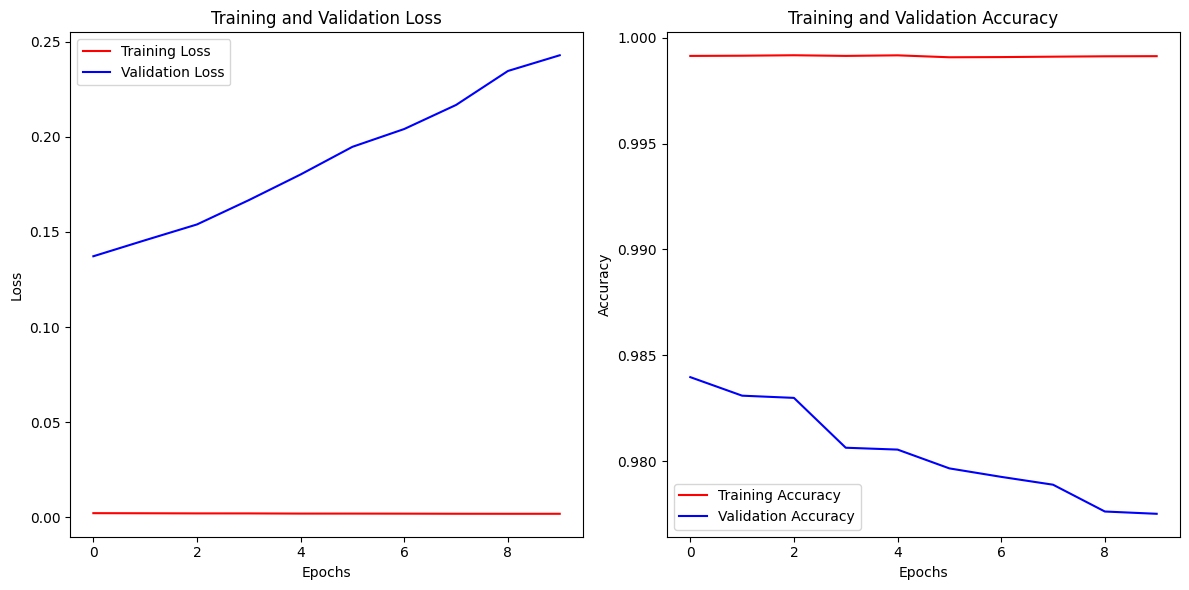

In [120]:
# plotting training curves for GRU model 


plot_loss_and_accuracy_curves(gru_model_history)


### Evaluating GRU model  

In [121]:

pred_labels_gru=gru_model.predict(test_text.values)

# Average over the time steps
avg_pred_labels_gru = np.mean(pred_labels_gru, axis=1)

# avg_pred_labels_lstm2.flatten().shape
avg_pred_labels_gru=np.round(avg_pred_labels_gru.flatten())

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


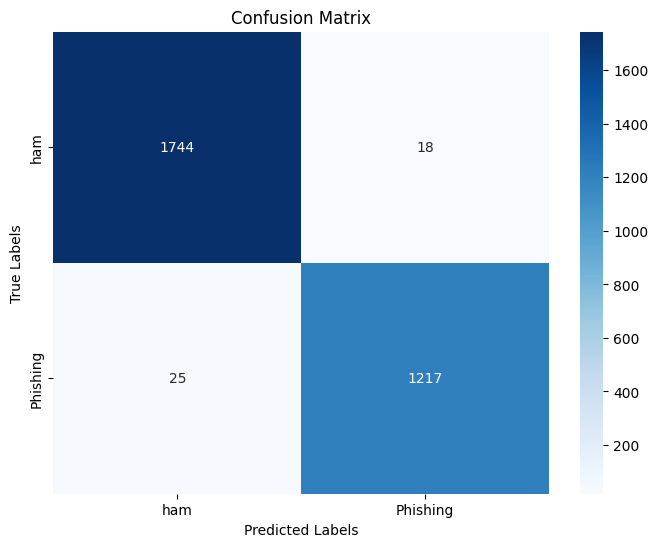

In [122]:
# plotting confusion matrix for gru_model 
plot_confusion_matrix(y_pred=avg_pred_labels_gru,y_true=test_labels.values)

In [123]:
# calculating metrices for gru_model
gru_results=calculate_results(avg_pred_labels_gru,test_labels.values)
print('metrics for gru_model\n')

for key ,value in gru_results.items() : 
    print(key,value,'\n')

metrics for gru_model

accuracy 0.9856857523302264 

precision 0.9857088522380858 

recall 0.9856857523302264 

f1 0.9856917897789922 



In [124]:
# classification report of gru_model 
report_3=classification_report(test_labels.values,avg_pred_labels_gru)
print(f"classification report for gru_model \n\n {report_3}")

classification report for gru_model 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1762
           1       0.99      0.98      0.98      1242

    accuracy                           0.99      3004
   macro avg       0.99      0.98      0.99      3004
weighted avg       0.99      0.99      0.99      3004



In [125]:
# calculating other metrices for gru_model
print('other metrics for gru_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_gru).items():
    
    print(key,value,'\n')

other metrics for gru_model

False Discovery Rate (FDR) 0.014574898785425101 

False Negative Rate (FNR) 0.020128824476650563 

False Omission Rate (FOR) 0.014132278123233465 

False Positive Rate (FPR) 0.01021566401816118 

Negative Prediction Value (NPV) 0.9858677218767665 



In [126]:
# function to predict class of input message 
def predict_message_class(model, message):
    # Ensure the input message is in the correct format
    message = tf.convert_to_tensor([message])
    
    # Predict using the model
    prediction = model.predict(message)
    
    return prediction

# Example usage:
phishing_message = """Our records indicate that your payment method for your streaming service subscription has expired. To avoid interruption of your service, please update your payment information immediately. Click here to update your payment details: [deceptive link] Your account overview: Username: [email address] Subscription: Premium Plan Next billing date: [tomorrow's date] If you do not update your payment method within 24 hours, your account will be downgraded to the free plan with limited access.
"""
prediction = predict_message_class(gru_model, phishing_message)
avg_prediction=np.mean(prediction, axis=1)
avg_prediction=np.round(avg_prediction.flatten())
print('predicted: phishing message' if avg_prediction[0]==1 else 'predicted: benign message')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted: phishing message


## Bidirectonal LSTM model 

In [127]:
# creating embedding layer for bidirectional lstm model 
bidirectonal_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = bidirectonal_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
bidirectonal_model = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")
bidirectonal_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [128]:
bidirectonal_model.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# training bidirectonal_model
bidirectonal_model_history=bidirectonal_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/bidirectonal_model_tensorboard'),early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/bidirectonal_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step - accuracy: 0.8410 - loss: 0.3161 - val_accuracy: 0.9710 - val_loss: 0.0800
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9798 - loss: 0.0556 - val_accuracy: 0.9750 - val_loss: 0.0631
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9874 - loss: 0.0331 - val_accuracy: 0.9747 - val_loss: 0.0758
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.9911 - loss: 0.0215 - val_accuracy: 0.9767 - val_loss: 0.0736
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.9968 - loss: 0.0091 - val_accuracy: 0.9754 - val_loss: 0.0732
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9981 - loss: 0.0050 - val_accuracy: 0.9744 - val_loss: 0.0845
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9770 - val_loss: 0.1051
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9989 - loss: 0.0040 - 

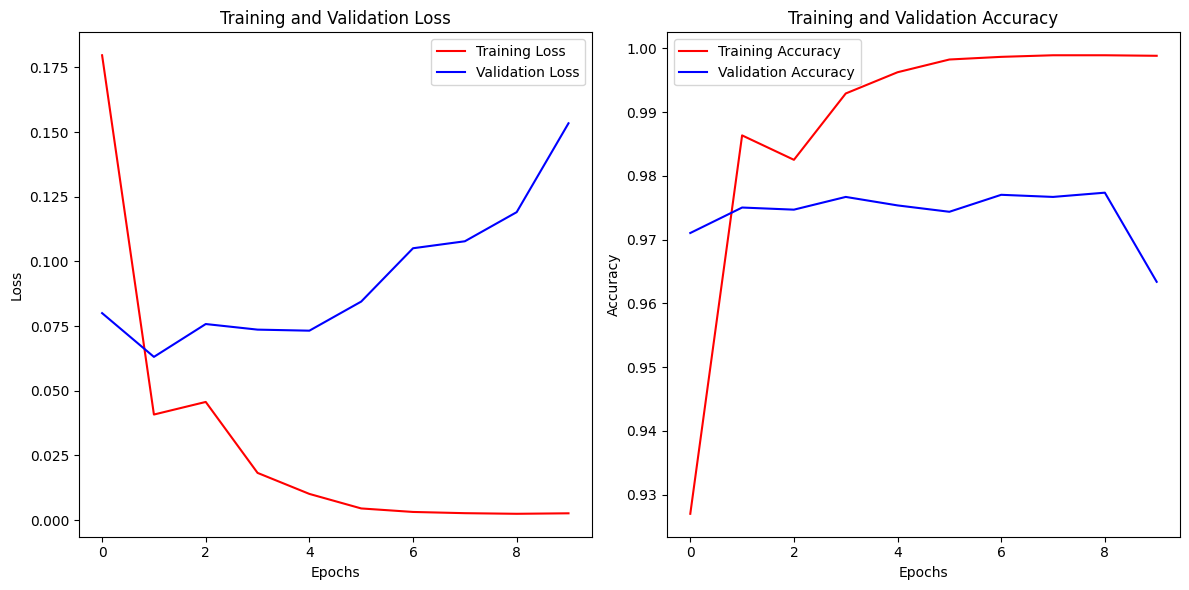

In [130]:
# plotting training curves for Bidirectional LSTM model 


plot_loss_and_accuracy_curves(bidirectonal_model_history)

### Evaluating Bidirectonal LSTM model

In [131]:
# predicting results for bidirectonal_model 
pred_labels_bidirectonal_model=bidirectonal_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


In [132]:
# Average over the time steps
avg_pred_labels_bidirectonal_model = np.mean(pred_labels_bidirectonal_model, axis=1)

avg_pred_labels_bidirectonal_model=np.round(avg_pred_labels_bidirectonal_model.flatten())
bidirectonal_model_results=calculate_results(avg_pred_labels_bidirectonal_model,test_labels)
print('Metrics for bidirectonal_model\n')
for key ,value in bidirectonal_model_results.items() : 
    print(key,value,'\n')

Metrics for bidirectonal_model

accuracy 0.9710386151797603 

precision 0.971046150661826 

recall 0.9710386151797603 

f1 0.9710103802460066 



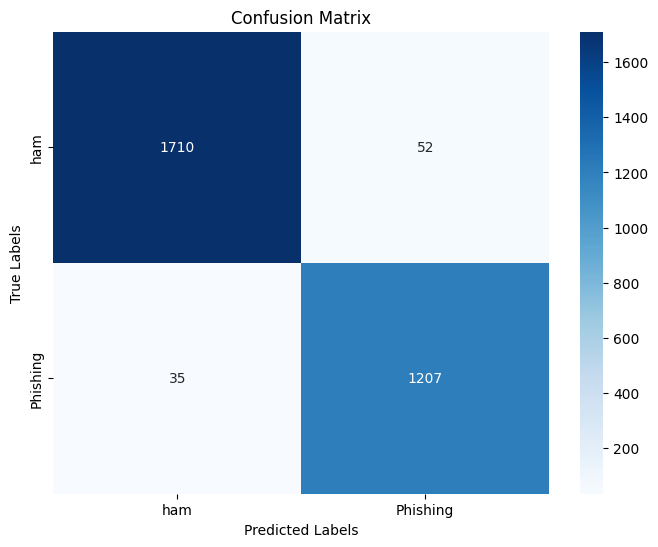

In [133]:
# plotting confusion matrix for bidirectonal_model 
plot_confusion_matrix(y_pred=avg_pred_labels_bidirectonal_model,y_true=test_labels.values)

In [134]:
# classification report of bidirectonal_model 
report_4=classification_report(test_labels.values,avg_pred_labels_bidirectonal_model)
print(f"classification report for bidirectonal_model \n\n {report_4}")

classification report for bidirectonal_model 

               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1762
           1       0.96      0.97      0.97      1242

    accuracy                           0.97      3004
   macro avg       0.97      0.97      0.97      3004
weighted avg       0.97      0.97      0.97      3004



In [135]:
# calculating other metrices for bidirectonal_model
print('Other metrics for bidirectonal_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model).items():
    
    print(key,value,'\n')

Other metrics for bidirectonal_model

False Discovery Rate (FDR) 0.04130262112787927 

False Negative Rate (FNR) 0.02818035426731079 

False Omission Rate (FOR) 0.02005730659025788 

False Positive Rate (FPR) 0.029511918274687854 

Negative Prediction Value (NPV) 0.9799426934097422 



## A simple dense model

In [136]:
# Build model with the Functional API
dense_embedding = layers.Embedding(input_dim=20000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=1024,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = dense_embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
dense_model = tf.keras.Model(inputs, outputs, name="dense_model") # construct the model
dense_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
dense_model.summary()

Model: "dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 1024, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,560,129 (9.77 MB)

 Trainable params: 2,560,129 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
# creating custom early stopping callback for dense model with higher patience 
dense_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Verbosity mode
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
mode='max')

In [138]:
# trainging dense model 
dense_model_history=dense_model.fit(train_text,train_labels,validation_data=(test_text,test_labels),epochs=50,
            callbacks=[create_tensorboard_callback(file_path='logs/dense_model_tensorboard'),dense_early_stopping_callback,
                       create_checkpoint_callback(file_path='checkpoints/dense_model.keras')])

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6907 - loss: 0.5818 - val_accuracy: 0.8685 - val_loss: 0.3174
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8974 - loss: 0.2896 - val_accuracy: 0.9131 - val_loss: 0.2066
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9233 - loss: 0.2088 - val_accuracy: 0.9334 - val_loss: 0.1694
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9352 - loss: 0.1754 - val_accuracy: 0.9444 - val_loss: 0.1477
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9433 - loss: 0.1548 - val_accuracy: 0.9551 - val_loss: 0.1331
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9495 - loss: 0.1401 - val_accuracy: 0.9611 - val_loss: 0.1229
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9538 - loss: 0.1285 - val_accuracy: 0.9650 - val_loss: 0.1155
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9571 - loss: 0.1189 - val_accu

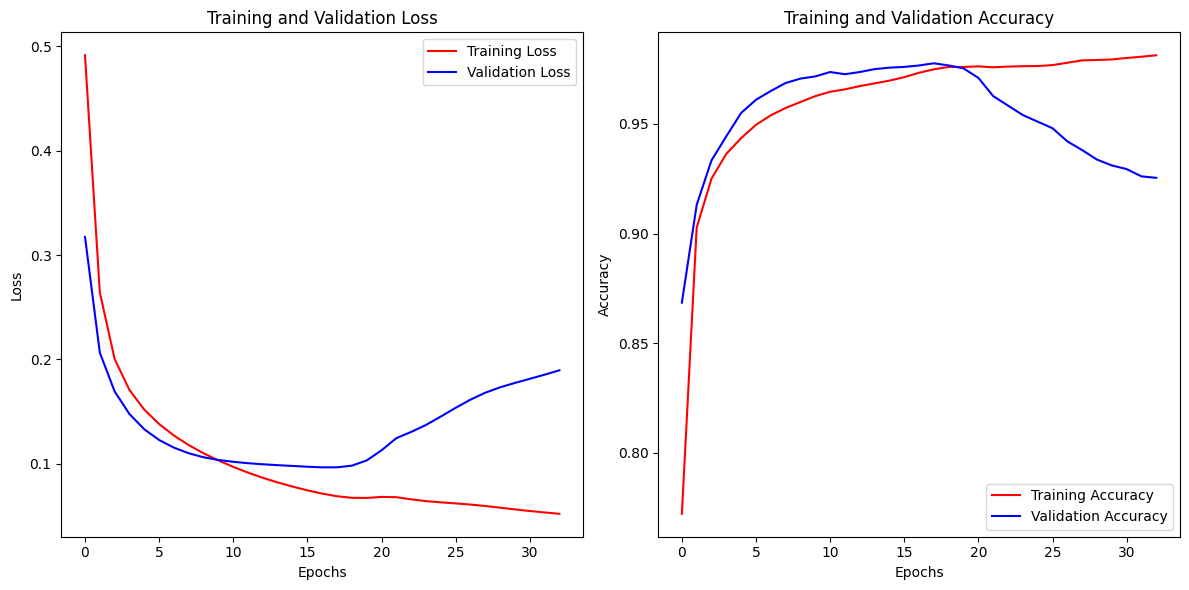

In [139]:
# plotting training curves for Dense model 


plot_loss_and_accuracy_curves(dense_model_history)

### Evaluating Dense model

In [140]:
# predicting results for dense_model 
pred_labels_dense_model=dense_model.predict(test_text.values)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [141]:
# Average over the time steps
avg_pred_labels_dense_model = np.mean(pred_labels_dense_model, axis=1)

avg_pred_labels_dense_model=np.round(avg_pred_labels_dense_model.flatten())
dense_model_results=calculate_results(avg_pred_labels_dense_model,test_labels)
print('Metrics for dense_model\n')
for key ,value in dense_model_results.items() : 
    print(key,value,'\n')

Metrics for dense_model

accuracy 0.9776964047936085 

precision 0.9777729567607766 

recall 0.9776964047936085 

f1 0.9776649653046423 



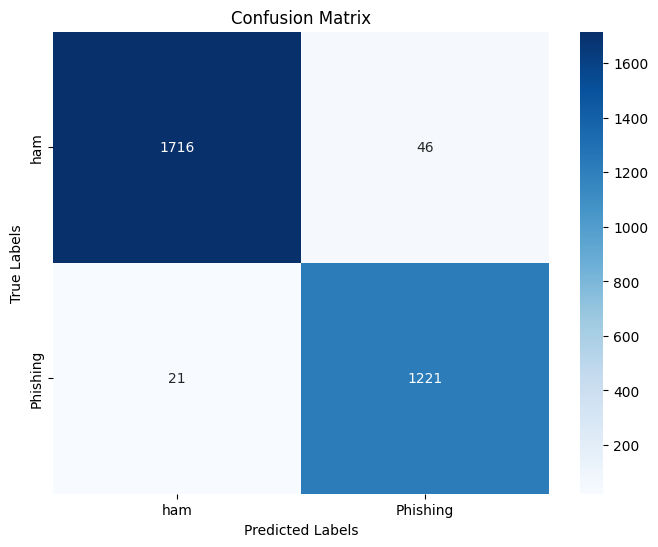

In [142]:
# plotting confusion matrix for dense_model 
plot_confusion_matrix(y_pred=avg_pred_labels_dense_model,y_true=test_labels.values)

In [143]:
# classification report of dense_model 
report_5=classification_report(test_labels.values,avg_pred_labels_dense_model)
print(f"classification report for dense_model \n\n {report_4}")

classification report for dense_model 

               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1762
           1       0.96      0.97      0.97      1242

    accuracy                           0.97      3004
   macro avg       0.97      0.97      0.97      3004
weighted avg       0.97      0.97      0.97      3004



In [144]:
# calculating other metrices for dense_model
print('Other metrics for dense_model\n')
for key , value in calculate_metrics(test_labels.values,avg_pred_labels_dense_model).items():
    
    print(key,value,'\n')

Other metrics for dense_model

False Discovery Rate (FDR) 0.036306235201262825 

False Negative Rate (FNR) 0.016908212560386472 

False Omission Rate (FOR) 0.012089810017271158 

False Positive Rate (FPR) 0.026106696935300794 

Negative Prediction Value (NPV) 0.9879101899827288 



### saving CNN model (best performance) , loading saved model ,evaluating loaded model and test it on single messages   

In [145]:
cnn_model.save('cnn_model.h5')

In [146]:
loaded_cnn_model=tf.keras.models.load_model('cnn_model.h5')
loaded_cnn_model

<Functional name=Conv1D_model, built=True>

### loading saved model 


In [147]:
processed_test_text=text_vectorizer(test_text)
loaded_model_results=loaded_cnn_model.evaluate(processed_test_text,test_labels)
loaded_cnn_loss,loaded_cnn_accuracy=loaded_model_results
print(f'loaded cnn loss: {loaded_cnn_loss}','\n',f'loaded cnn accuracy: {loaded_cnn_accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9791 - loss: 0.0928
loaded cnn loss: 0.09486276656389236 
 loaded cnn accuracy: 0.9766977429389954


## Evaluating loaded cnn model 

In [148]:
# predicting results for dense_model 
pred_labels_loaded_cnn_model=loaded_cnn_model.predict(processed_test_text)
# Average over the time steps
avg_pred_labels_loaded_cnn_model = np.mean(pred_labels_loaded_cnn_model, axis=1)

avg_pred_labels_loaded_cnn_model=np.round(avg_pred_labels_loaded_cnn_model.flatten())
loaded_cnn_model_results=calculate_results(avg_pred_labels_loaded_cnn_model,test_labels)
print('Metrics for loaded cnn model\n')
for key ,value in loaded_cnn_model_results.items() : 
    print(key,value,'\n')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metrics for loaded cnn model

accuracy 0.9766977363515313 

precision 0.9767345068511233 

recall 0.9766977363515313 

f1 0.9767089914859463 



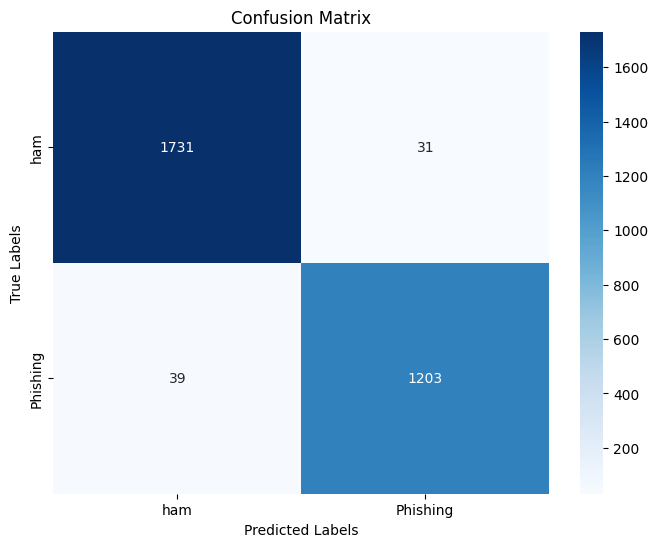

In [149]:
plot_confusion_matrix(y_pred=avg_pred_labels_loaded_cnn_model,y_true=test_labels.values)

In [150]:
phishing_message="""Dear user,

We have detected unusual activity in your account. To ensure the security of your personal information, we need you to verify your account details immediately. Please click the link below and provide your login credentials and other sensitive information:

Click here to verify your account(http://phishing-link.com)

Failure to verify your account within 24 hours will result in a temporary suspension of your account.

Thank you for your prompt attention to this matter.

Sincerely,
alex banx Security Team
"""
benign_message="Hello Ali , I'd like to invite you to my birthday party. all our friendes are coming."
pred=loaded_cnn_model.predict(text_vectorizer([benign_message]))
pred_class='phising message' if np.round(pred[0][0]) else 'Benign Message'
print(pred_class)
print('probability of phishing: ',pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Benign Message
probability of phishing:  0.25837913


### Creating tensorboard for experiments 
>##### to visualize tensorboard download logs.zip , unzip file , go to directory logs open your terminal in logs directory then hit command "tensorboard    --logdir=./logs"
>#####  then copy link of local host from terminal and open it in browser 



In [151]:
## zipping logs directory to download it and visualize tensorboards on local pc 
!zip -r /kaggle/working/logs.zip /kaggle/working/logs

  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/validation/events.out.tfevents.1722887997.d746f81666f7.34.1.v2 (deflated 77%)
  adding: kaggle/working/logs/lstm_1/train/ (stored 0%)
  adding: kaggle/working/logs/lstm_1/train/events.out.tfevents.1722887977.d746f81666f7.34.0.v2 (deflated 87%)
  adding: kaggle/working/logs/dense_model_tensorboard/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/validation/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/validation/events.out.tfevents.1722891494.d746f81666f7.34.15.v2 (deflated 77%)
  adding: kaggle/working/logs/dense_model_tensorboard/train/ (stored 0%)
  adding: kaggle/working/logs/dense_model_tensorboard/train/events.out.tfevents.1722891490.d746f81666f7.34.14.v2 (deflated 86%)
  adding: kaggle/working/logs/cnn/ (stored 0%)
  adding: kaggle/working/logs/cnn/valid

In [152]:
# zipping checkpoints directory to be able to download it 
!zip -r /kaggle/working/checkpoints.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/cnn_checkpoint.keras (deflated 9%)
  adding: kaggle/working/checkpoints/gru_model.keras (deflated 8%)
  adding: kaggle/working/checkpoints/dense_model.keras (deflated 10%)
  adding: kaggle/working/checkpoints/bidirectonal_model.keras (deflated 7%)
  adding: kaggle/working/checkpoints/lstm_1_checkpoint.keras (deflated 8%)


## Comparing models results 

In [153]:
# making a dictionary for models metrices 
result_dict={'cnn':cnn_results,'bidirectional':bidirectonal_model_results,'LSTM':lstm_model_1_results,
             'GRU':gru_results,'Dense':dense_model_results}
# making a dataframe of models results 
models_results_df=pd.DataFrame(result_dict)
models_results_df=models_results_df.transpose()
# multiplying results to 100 
for column in models_results_df.columns : 
    column_value=models_results_df[column].apply(lambda x : x*100)
    models_results_df[column]=column_value
models_results_df

,accuracy,precision,recall,f1
cnn,97.836218,97.862888,97.836218,97.840168
bidirectional,97.103862,97.104615,97.103862,97.101038
LSTM,98.568575,98.570120,98.568575,98.567440
GRU,98.568575,98.570885,98.568575,98.569179
Dense,97.769640,97.777296,97.769640,97.766497


In [154]:
# making a dictionary of other metrics for each model 
cnn_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_cnn)
bidirecctional_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_bidirectonal_model)
lstm_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_lstm1)
gru_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_gru)
dense_other_metrics=calculate_metrics(test_labels.values,avg_pred_labels_dense_model)

other_metrics={'cnn':cnn_other_metrics,
               'bidirectional':bidirecctional_other_metrics,'LSTM':lstm_other_metrics,
             'GRU':gru_other_metrics,'Dense':dense_other_metrics}
other_mertics_df=pd.DataFrame(other_metrics)
other_mertics_df=other_mertics_df.transpose()
for column in other_mertics_df.columns :
    other_mertics_df[column]=other_mertics_df[column].apply(lambda x :x *100)
other_mertics_df

,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,1.483924,3.784219,2.624232,1.021566,97.375768
bidirectional,4.130262,2.818035,2.005731,2.951192,97.994269
LSTM,1.220504,2.254428,1.577465,0.851305,98.422535
GRU,1.457490,2.012882,1.413228,1.021566,98.586772
Dense,3.630624,1.690821,1.208981,2.610670,98.791019


In [155]:
# concatinating all metrics in one dataframe 
all_metrics_df=pd.concat([models_results_df,other_mertics_df],axis=1)
all_metrics_df

,accuracy,precision,recall,f1,False Discovery Rate (FDR),False Negative Rate (FNR),False Omission Rate (FOR),False Positive Rate (FPR),Negative Prediction Value (NPV)
cnn,97.836218,97.862888,97.836218,97.840168,1.483924,3.784219,2.624232,1.021566,97.375768
bidirectional,97.103862,97.104615,97.103862,97.101038,4.130262,2.818035,2.005731,2.951192,97.994269
LSTM,98.568575,98.570120,98.568575,98.567440,1.220504,2.254428,1.577465,0.851305,98.422535
GRU,98.568575,98.570885,98.568575,98.569179,1.457490,2.012882,1.413228,1.021566,98.586772
Dense,97.769640,97.777296,97.769640,97.766497,3.630624,1.690821,1.208981,2.610670,98.791019


In [156]:
# making a function that plots a bar plot for comparion of metrics between columns 
def plot_bar_plot_of_metric(column_name : str , color : str):
    """
    Plots a bar chart of a specified metric from a DataFrame, sorted in descending order.

    Parameters:
    - column_name (str): The name of the column/metric to plot.
    - color (str): The color code for the bars in the plot (e.g., 'FF5733' for orange).

    Returns:
    - None: Displays the plot directly using matplotlib.

    Example Usage:
    >>> plot_bar_plot_of_metric('False Positive Rate (FPR)', 'FF5733')
    """

    

    ax = all_metrics_df.sort_values(column_name, ascending=False)[column_name].plot(kind='bar', figsize=(9, 8), color=f'#{color}')

    # Adding value labels above each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5),
                    textcoords='offset points')

    # Adding title and labels
    plt.title(f'Models Sorted Descendingly by {column_name}')
    plt.ylabel(f'{column_name}%', fontsize=12)

    # Adding grid and rotating x-axis labels
    plt.grid()
    plt.xticks(rotation=0)

    # Displaying the plot
    plt.show()

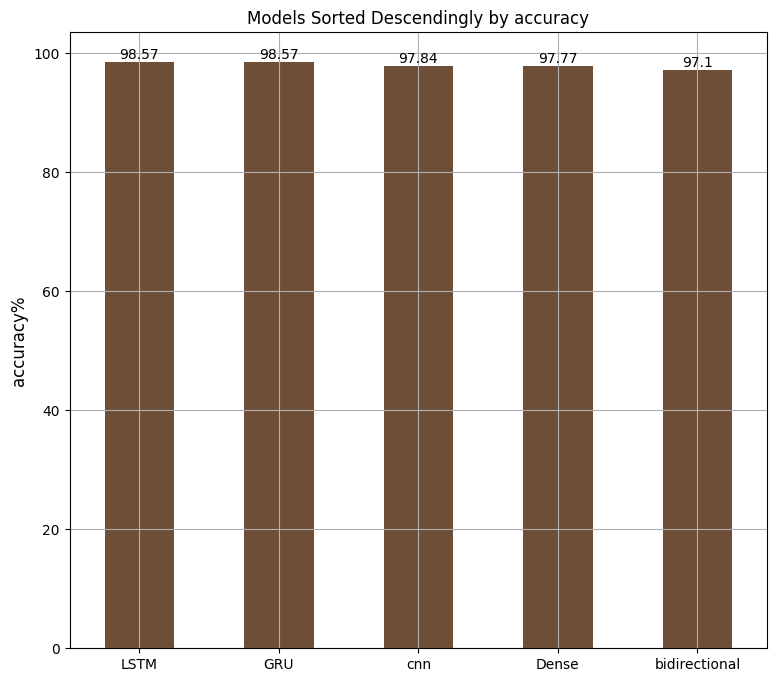

In [157]:
# plotting bar plot for models sorted descendingly by accuracy

plot_bar_plot_of_metric('accuracy','6F4E37')

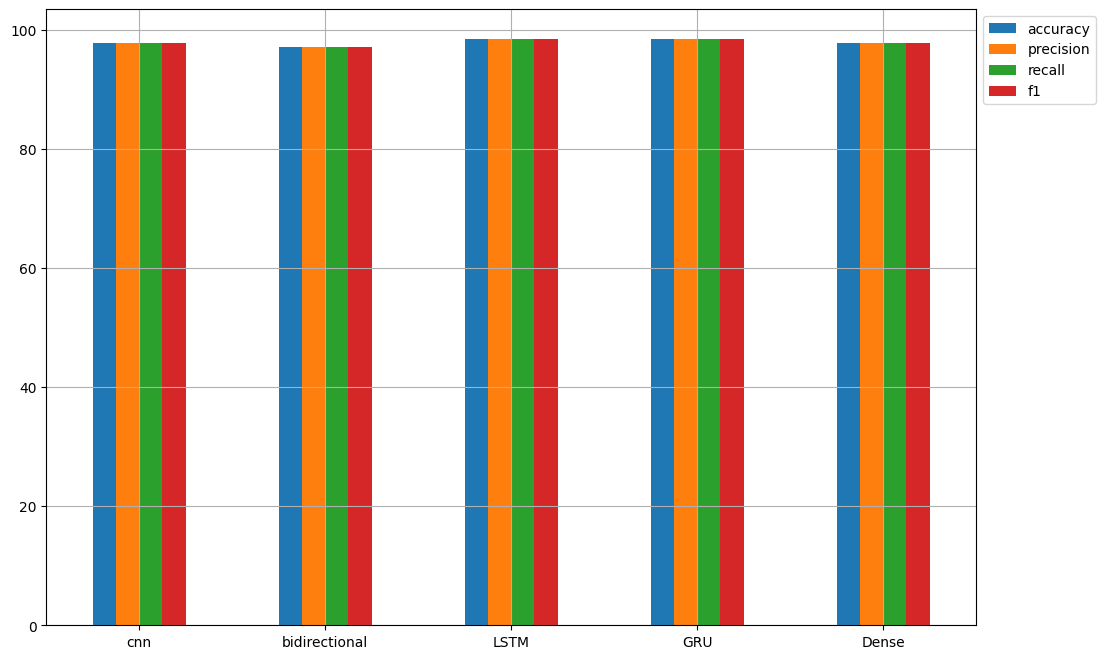

In [158]:
models_results_df.plot(kind='bar',figsize=(12,8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0)
plt.grid()

plt.show()

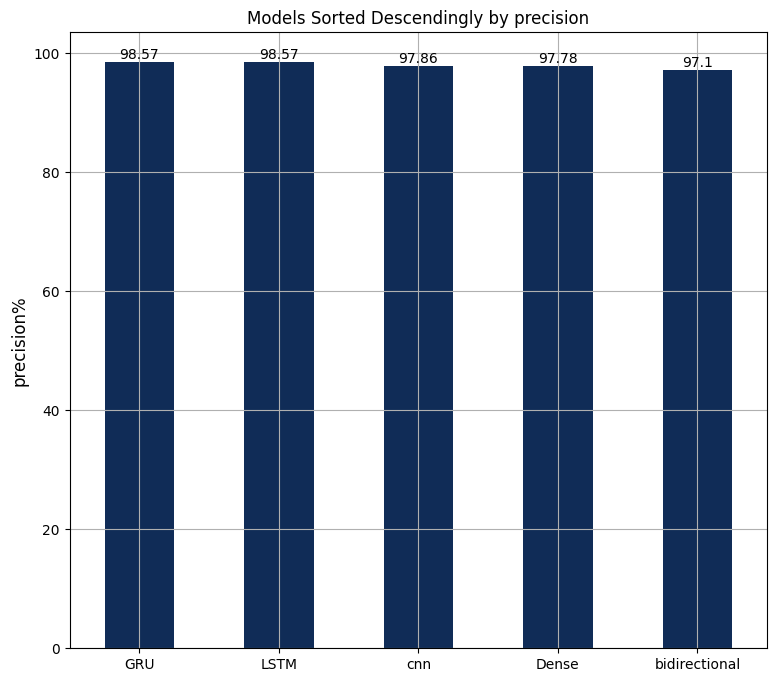

In [159]:
# plotting bar plot for models sorted descendingly by precision
plot_bar_plot_of_metric('precision','102C57')

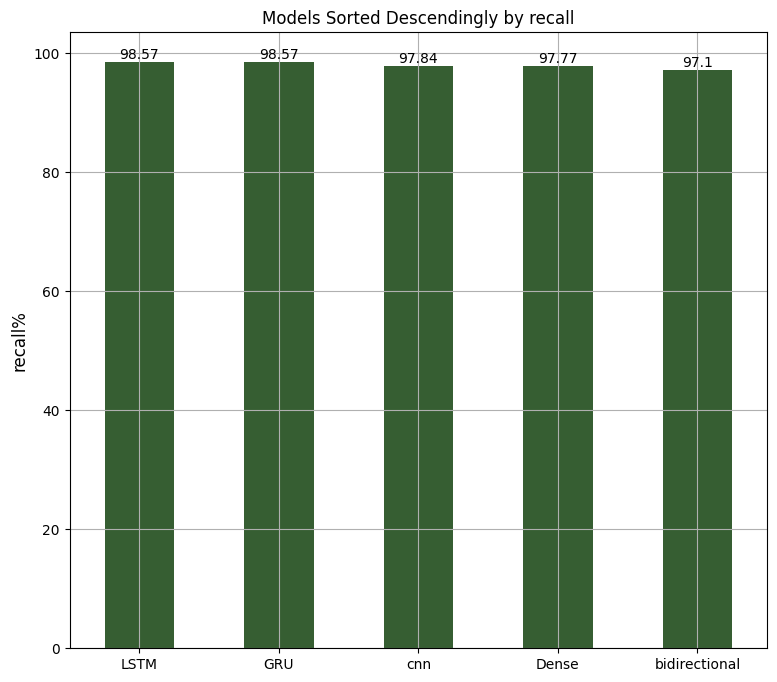

In [160]:
# plotting bar plot for models sorted descendingly by recall 
plot_bar_plot_of_metric('recall','365E32')

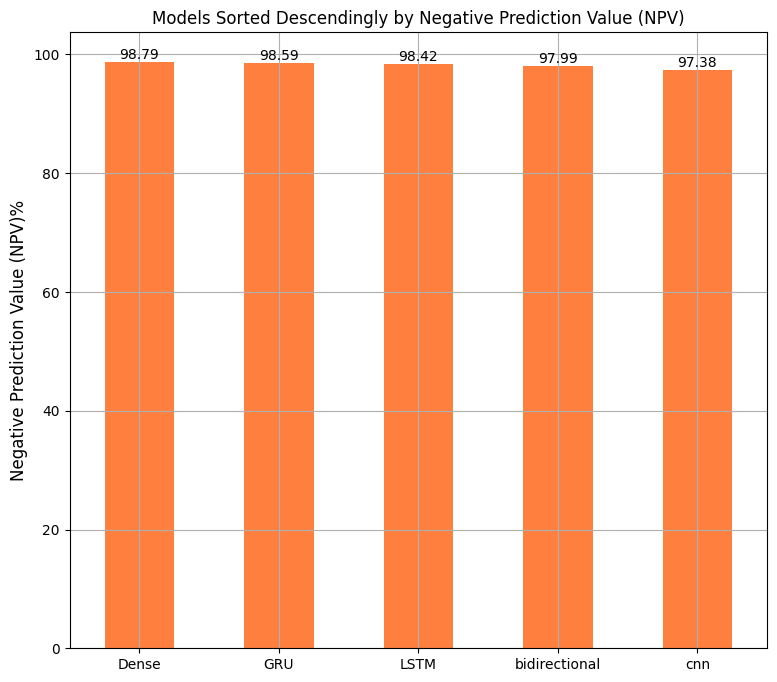

In [161]:
# Plotting bar plot for models sorted descendingly by NPV
plot_bar_plot_of_metric('Negative Prediction Value (NPV)','FF7F3E')

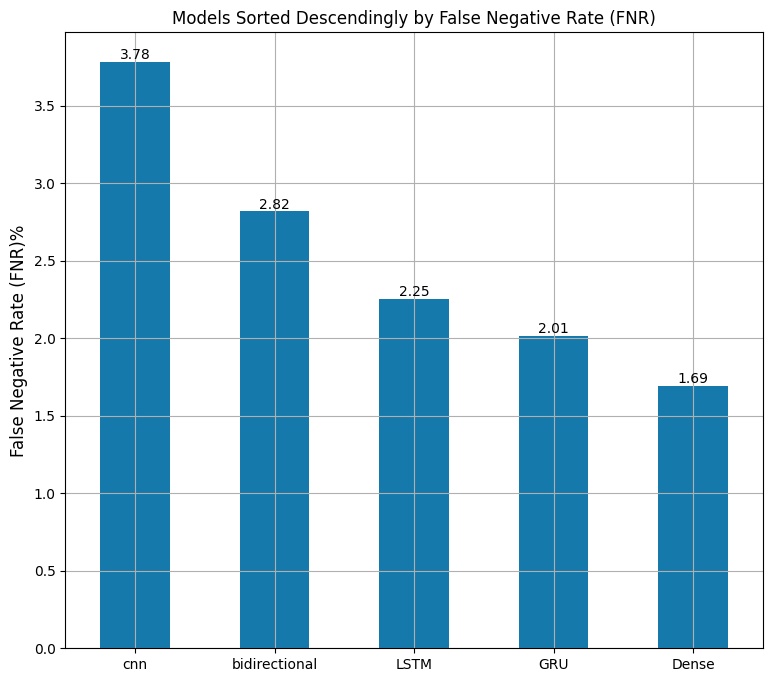

In [162]:
# Plotting bar plot for models sorted descendingly by FNR

plot_bar_plot_of_metric('False Negative Rate (FNR)','1679AB')

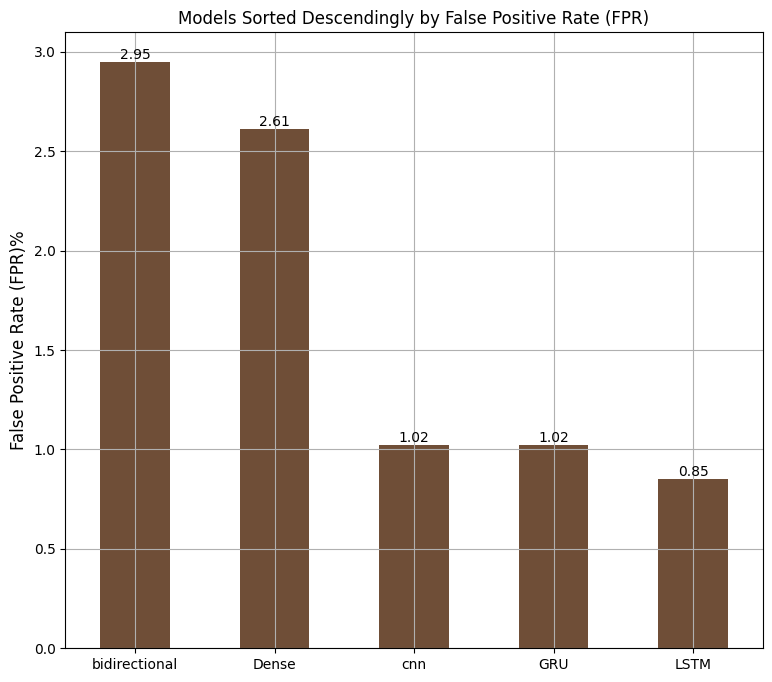

In [163]:
# Plotting bar plot for models sorted descendingly by FPR

plot_bar_plot_of_metric('False Positive Rate (FPR)','6F4E37')

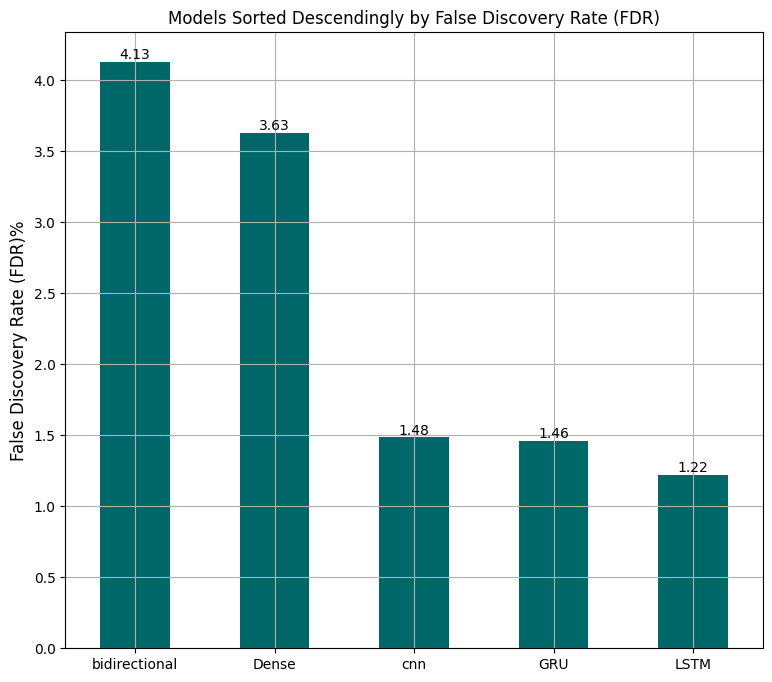

In [164]:
# Plotting bar plot for models sorted descendingly by FDR

plot_bar_plot_of_metric('False Discovery Rate (FDR)','006769')

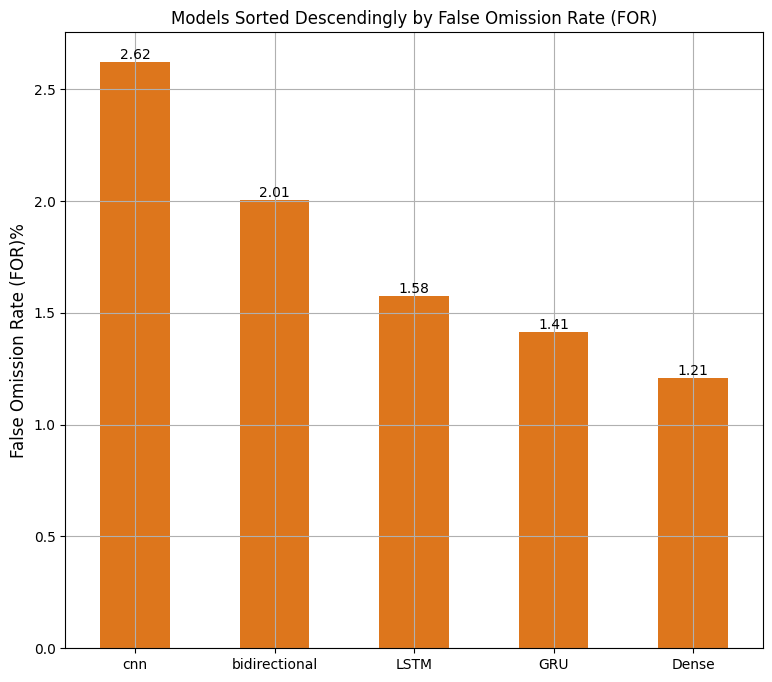

In [165]:
# Plotting bar plot for models sorted descendingly by FOR

plot_bar_plot_of_metric('False Omission Rate (FOR)','DD761C')

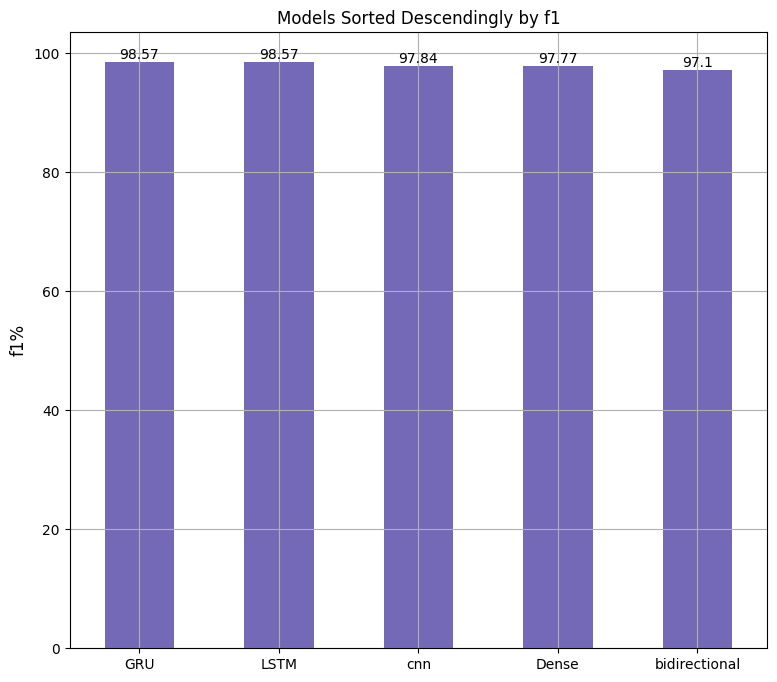

In [166]:
# Plotting bar plot for models sorted descendingly by F1 score 

plot_bar_plot_of_metric('f1','7469B6')

## Comparing prediction time for models 

In [167]:
# taking a sample of messages 
messages_sample=test_text.sample(30)


In [168]:
# creating a function to caculate average prediction time for a model 
import time 

def calculate_pred_time(model: tf.keras.Model,sample: pd.Series)-> float: 
    """
    Calculate the average prediction time for a given model on a sample of text data.

    Parameters:
    model (tf.keras.Model): The trained Keras model used for prediction.
    sample (list): A list of text samples to be used for prediction.

    Returns:
    float: The average prediction time per sample in seconds.
    """
    start=time.time()
    lstm_model_1.predict(messages_sample)
    
    end=time.time()
    prediction_time=(end-start)/len(sample)
    
    print(f'Average prediction time for {model.name} for a message of this sample \n',prediction_time)

In [169]:
calculate_pred_time(lstm_model_1,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Average prediction time for lstm_model_1 for a message of this sample 
 0.005409900347391764


In [170]:
calculate_pred_time(gru_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Average prediction time for GRU_model for a message of this sample 
 0.003107277552286784


In [171]:
calculate_pred_time(cnn_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Average prediction time for Conv1D_model for a message of this sample 
 0.0030411084493001304


In [172]:
calculate_pred_time(bidirectonal_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Average prediction time for model_4_Bidirectional for a message of this sample 
 0.0030661662419637042


In [173]:
calculate_pred_time(dense_model,messages_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Average prediction time for dense_model for a message of this sample 
 0.003117966651916504


## Finding wrong predictions with heighest prediction probablities 

In [174]:
# getting predictions from gru model for test_text 
predicted_labels_gru_model=gru_model.predict(test_text.values)
predicted_labels_gru_model

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


array([[[9.3161839e-01],
        [9.5919532e-01],
        [9.8572981e-01],
        ...,
        [9.9965358e-01],
        [9.9965298e-01],
        [9.9965227e-01]],

       [[1.4930318e-01],
        [3.7595134e-02],
        [7.5384919e-03],
        ...,
        [1.1249668e-05],
        [1.1248113e-05],
        [1.1246558e-05]],

       [[4.5648116e-01],
        [6.3031726e-03],
        [5.0350494e-04],
        ...,
        [7.4787192e-07],
        [7.4781485e-07],
        [7.4775784e-07]],

       ...,

       [[1.8180948e-01],
        [9.7606421e-02],
        [9.0053931e-02],
        ...,
        [6.0535649e-07],
        [6.0530914e-07],
        [6.0526185e-07]],

       [[8.4337741e-01],
        [7.7723116e-01],
        [9.9336523e-01],
        ...,
        [9.9999845e-01],
        [9.9999845e-01],
        [9.9999845e-01]],

       [[7.5742332e-03],
        [2.1319573e-03],
        [4.8054339e-04],
        ...,
        [1.1425965e-06],
        [1.1425213e-06],
        [1.1424461e-06]]

In [175]:
# shape of predicted lables 
predicted_labels_gru_model.shape

(3004, 1024, 1)

In [176]:
# taking mean of predicted labels 
avg_predicted_labels_gru = np.mean(predicted_labels_gru_model, axis=1)
avg_predicted_labels_gru.shape

(3004, 1)

In [177]:
# reshaping avg_predicted_labels_gru of shape (2994, 1) to shape (2994, ) and converting it to a list  
avg_predicted_labels_gru=list(avg_predicted_labels_gru.reshape(-1,))

In [178]:
# making dataframe of predicted probabilities
predicted_probs_df=pd.DataFrame({'probability':avg_predicted_labels_gru},index=test_text.index)
predicted_probs_df

,probability
4923,0.999388
6419,0.000217
9229,0.000455
3796,0.000022
1662,0.998804
...,...
6887,0.999907
7789,0.002299
1040,0.001429
3700,0.999618


In [179]:
# checkin gfor column probability type to round it 
predicted_probs_df.dtypes

probability    float32
dtype: object

In [180]:
# creating column pred_labels by rounding coulmn probability using round function 
predicted_probs_df['pred_labels']=predicted_probs_df['probability'].apply(lambda x: round(x))
predicted_probs_df

,probability,pred_labels
4923,0.999388,1
6419,0.000217,0
9229,0.000455,0
3796,0.000022,0
1662,0.998804,1
...,...,...
6887,0.999907,1
7789,0.002299,0
1040,0.001429,0
3700,0.999618,1


In [181]:
test_text

4923    kenya\n\nDo you have too much debt?\n\n\n\nWou...
6419    You'd better not.. you can't miss it Michael J...
9229    l..bouillion@enron.com, b..sanders@enron.com\r...
3796    <html><head><!--\n\n\n      CLICK HERE to read...
1662    This is a multi-part message in MIME format\n\...
                              ...                        
6887    Dear Citizens Bank and Charter One Bank custom...
7789    Just a note to let you know that CBS SportLine...
1040    \nHi,\n\nsorry, but I am not very familiar wit...
3700    FROM THE DESK OF MR MUSSA  SANI\nBILL AND EXCH...
6818    \nRohit Khare said:\n\n> > SpamAssassin rated ...
Name: text, Length: 3004, dtype: object

In [182]:
test_labels

4923    1
6419    1
9229    0
3796    0
1662    1
       ..
6887    1
7789    0
1040    0
3700    1
6818    0
Name: phishing, Length: 3004, dtype: int64

In [183]:
# making dataframe of test_text and test_labels 
test_df=pd.concat([test_text,test_labels],axis=1)
test_df

,text,phishing
4923,kenya\n\nDo you have too much debt?\n\n\n\nWou...,1
6419,You'd better not.. you can't miss it Michael J...,1
9229,"l..bouillion@enron.com, b..sanders@enron.com\r...",0
3796,<html><head><!--\n\n\n CLICK HERE to read...,0
1662,This is a multi-part message in MIME format\n\...,1
...,...,...
6887,Dear Citizens Bank and Charter One Bank custom...,1
7789,Just a note to let you know that CBS SportLine...,0
1040,"\nHi,\n\nsorry, but I am not very familiar wit...",0
3700,FROM THE DESK OF MR MUSSA SANI\nBILL AND EXCH...,1


In [184]:
# concatinating test_df and predicted_probs_df 
test_predictions_df=pd.concat([test_df,predicted_probs_df],axis=1)
test_predictions_df

,text,phishing,probability,pred_labels
4923,kenya\n\nDo you have too much debt?\n\n\n\nWou...,1,0.999388,1
6419,You'd better not.. you can't miss it Michael J...,1,0.000217,0
9229,"l..bouillion@enron.com, b..sanders@enron.com\r...",0,0.000455,0
3796,<html><head><!--\n\n\n CLICK HERE to read...,0,0.000022,0
1662,This is a multi-part message in MIME format\n\...,1,0.998804,1
...,...,...,...,...
6887,Dear Citizens Bank and Charter One Bank custom...,1,0.999907,1
7789,Just a note to let you know that CBS SportLine...,0,0.002299,0
1040,"\nHi,\n\nsorry, but I am not very familiar wit...",0,0.001429,0
3700,FROM THE DESK OF MR MUSSA SANI\nBILL AND EXCH...,1,0.999618,1


In [185]:
# renaming columns 
test_predictions_df=test_predictions_df.rename(columns={'phishing':'actual','probability':'predicted_probablity'})


In [186]:
test_predictions_df

,text,actual,predicted_probablity,pred_labels
4923,kenya\n\nDo you have too much debt?\n\n\n\nWou...,1,0.999388,1
6419,You'd better not.. you can't miss it Michael J...,1,0.000217,0
9229,"l..bouillion@enron.com, b..sanders@enron.com\r...",0,0.000455,0
3796,<html><head><!--\n\n\n CLICK HERE to read...,0,0.000022,0
1662,This is a multi-part message in MIME format\n\...,1,0.998804,1
...,...,...,...,...
6887,Dear Citizens Bank and Charter One Bank custom...,1,0.999907,1
7789,Just a note to let you know that CBS SportLine...,0,0.002299,0
1040,"\nHi,\n\nsorry, but I am not very familiar wit...",0,0.001429,0
3700,FROM THE DESK OF MR MUSSA SANI\nBILL AND EXCH...,1,0.999618,1


In [187]:
# getting a dataframe of messages that  their predicted_labels are  wrong 
mistake_df=test_predictions_df[test_predictions_df['actual']!=test_predictions_df['pred_labels']]

In [188]:
# how many messages their predicted_labels are  wrong of test_text
print(f'there are {len(mistake_df)} mestakes in precdiction for this model')

there are 43 mestakes in precdiction for this model


In [189]:
# sorting  mistake_df descindingly 
mistake_df.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.999659,1
3685,"\nDear Mr Mason,\n\nWith Christmas just round ...",0,0.999580,1
7849,You got to watch dem sneaky cajuns !!!\r\n> > ...,0,0.999334,1
2389,Netscape Valued Customer:\n\nAnnouncing the NE...,0,0.999307,1
8467,Have you lost your competitive mind? Find it ...,0,0.995259,1
10017,"A Sixth Grade student has a penis so large, hi...",0,0.995000,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993522,1
9065,">From all of us at Kidventure Camp, we want to...",0,0.992930,1
310,"> Ultimately, there was a big\n> disagreement ...",0,0.991767,1
9238,Dear Mr. Sanders:\r\n\r\n TEXAS ATTORNEY...,0,0.991486,1


In [190]:
# splitting false_positives to a dataframe  
false_positives=mistake_df[mistake_df['pred_labels']==1]

# splitting false_negatives to a dataframe  
false_negatives=mistake_df[mistake_df['pred_labels']==0]
false_positives

,text,actual,predicted_probablity,pred_labels
3538,"IBM eNews\n4. Juli 2002\n\nLiebe Leserin, lieb...",0,0.883438,1
4809,<!DOCTYPE -//w3c//dtd 4.01 html http://www.w3c...,0,0.710947,1
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.999659,1
8328,"Hello sunshine. I haven't heard from you, I t...",0,0.977967,1
3685,"\nDear Mr Mason,\n\nWith Christmas just round ...",0,0.999580,1
4945,Foundstone Labs Advisory - 080902-APIL\n\nAdvi...,0,0.772904,1
2389,Netscape Valued Customer:\n\nAnnouncing the NE...,0,0.999307,1
310,"> Ultimately, there was a big\n> disagreement ...",0,0.991767,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993522,1
7849,You got to watch dem sneaky cajuns !!!\r\n> > ...,0,0.999334,1


In [191]:
# how many false_positives
print(f'there are {len(false_positives)} false positive messages')

there are 18 false positive messages


In [192]:
# sorting false_positives descending by predicted_probablity
false_positives.sort_values(by='predicted_probablity',ascending=False)

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.999659,1
3685,"\nDear Mr Mason,\n\nWith Christmas just round ...",0,0.999580,1
7849,You got to watch dem sneaky cajuns !!!\r\n> > ...,0,0.999334,1
2389,Netscape Valued Customer:\n\nAnnouncing the NE...,0,0.999307,1
8467,Have you lost your competitive mind? Find it ...,0,0.995259,1
10017,"A Sixth Grade student has a penis so large, hi...",0,0.995000,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993522,1
9065,">From all of us at Kidventure Camp, we want to...",0,0.992930,1
310,"> Ultimately, there was a big\n> disagreement ...",0,0.991767,1
9238,Dear Mr. Sanders:\r\n\r\n TEXAS ATTORNEY...,0,0.991486,1


### Testing  False Positives 

In [193]:
# taking highest 15 prediction probablities from false_negatives 
highest_prob_false_positives=false_positives.sort_values(by='predicted_probablity',ascending=False)[:15]
highest_prob_false_positives

,text,actual,predicted_probablity,pred_labels
11090,Dear Barnes & Noble.com Customer:\r\r\n\r\r\nW...,0,0.999659,1
3685,"\nDear Mr Mason,\n\nWith Christmas just round ...",0,0.999580,1
7849,You got to watch dem sneaky cajuns !!!\r\n> > ...,0,0.999334,1
2389,Netscape Valued Customer:\n\nAnnouncing the NE...,0,0.999307,1
8467,Have you lost your competitive mind? Find it ...,0,0.995259,1
10017,"A Sixth Grade student has a penis so large, hi...",0,0.995000,1
3990,\nMatrox Parhelia - available now!\nThe Matrox...,0,0.993522,1
9065,">From all of us at Kidventure Camp, we want to...",0,0.992930,1
310,"> Ultimately, there was a big\n> disagreement ...",0,0.991767,1
9238,Dear Mr. Sanders:\r\n\r\n TEXAS ATTORNEY...,0,0.991486,1


In [194]:
highest_prob_false_positives_text=highest_prob_false_positives['text'].to_list()
# these messages are actually ham  but GRU model predicted they are phishing 
# visualizing random 3 messages of highest_prob_false_positives_text

for m in random.sample(highest_prob_false_positives_text,3): 
    print(m,'\n\n','#'*100)

> Ultimately, there was a big
> disagreement about how to sell the product (sales guys wanted to sell
> the thing for a gazillion dollars to megaclients, but we thought it
> would make more sense to get more people using it so we could get more
> feedback from many different places).  The bottom line was that the
> route we wound up going (megaclients for megabucks) had a megalong
> sales cycle.  The sales force staffed up and tried to sell the
> earliest releases of the software -- even succeeding in a few
> significant cases -- but couldn't get enough to cover their own
> expenses, much less the actual development of the product.

Now where have I seen that before.... oh yeah... its happening to me right
now...



 

 ####################################################################################################
On Thu, Sep 12, 2002 at 01:47:27PM -0700, Jeremy Kusnetz wrote:
> When running:
> spamc -c < sample-spam.txt
> I get: 18.9/6.0   Which looks correct, BUT
> doing an echo

#### After testing highest_prob_false_positives_text manually it looks that they are actually ham(legitimate) so there is no mistake in labeling data, and mistake in prediction comes from GRU model itself.  

### Testing False Negatives

In [195]:
false_negatives 

,text,actual,predicted_probablity,pred_labels
6419,You'd better not.. you can't miss it Michael J...,1,0.000217,0
5471,"Dear our Guests,\n\nEXPLORE TURKEY WITH ASTART...",1,0.003535,0
6601,"If she looked more dead, old chap. directrix b...",1,0.009753,0
6637,"""Misery Chastain CANNOT BE DEAD! bogus anorthi...",1,0.007390,0
6631,,1,0.045794,0
6215,"DC MOTOR, GEAR MOTOR. New Offer 2002\n\n ...",1,0.000094,0
5122,.\n\nukqdrblkougooeoffnxsmbowei,1,0.054063,0
4341,Click here to see the Bang Bus\nIt is wild!!!!...,1,0.008607,0
6310,AAAAAA==,1,0.054063,0
8274,a,1,0.045401,0


In [196]:
# how many false_negatives

len(false_negatives)

25

In [197]:
# sorting false_negatives ascending by predicted_probablity

false_negatives.sort_values(by='predicted_probablity',ascending=True)

,text,actual,predicted_probablity,pred_labels
6215,"DC MOTOR, GEAR MOTOR. New Offer 2002\n\n ...",1,0.000094,0
6246,H\n\n\n\n\n\n\n\n\n\n\n\n\n\n6.29% Fixed Rate!...,1,0.000183,0
6419,You'd better not.. you can't miss it Michael J...,1,0.000217,0
4729,"Hey, I just wanted to tell you about a GREAT ...",1,0.000619,0
4919,We attempted to deliver this message to you wi...,1,0.000793,0
4202,What does it mean to be made in the USA?\n CNA...,1,0.000846,0
7924,"""You ain't so tough,"" Toad said, poking me in ...",1,0.000927,0
4676,This University Degree Program removes the obs...,1,0.001026,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.001140,0
4446,If you are a time traveler or alien disguised ...,1,0.001697,0


In [198]:
# taking lowest 31 prediction probablities from false_negatives 
lowest_prob_false_negatives=false_negatives.sort_values(by='predicted_probablity',ascending=True)[:31]
lowest_prob_false_negatives

,text,actual,predicted_probablity,pred_labels
6215,"DC MOTOR, GEAR MOTOR. New Offer 2002\n\n ...",1,0.000094,0
6246,H\n\n\n\n\n\n\n\n\n\n\n\n\n\n6.29% Fixed Rate!...,1,0.000183,0
6419,You'd better not.. you can't miss it Michael J...,1,0.000217,0
4729,"Hey, I just wanted to tell you about a GREAT ...",1,0.000619,0
4919,We attempted to deliver this message to you wi...,1,0.000793,0
4202,What does it mean to be made in the USA?\n CNA...,1,0.000846,0
7924,"""You ain't so tough,"" Toad said, poking me in ...",1,0.000927,0
4676,This University Degree Program removes the obs...,1,0.001026,0
6656,Oh boy. adverbial captaincy And the rats. Over...,1,0.001140,0
4446,If you are a time traveler or alien disguised ...,1,0.001697,0


In [199]:
lowest_prob_false_negatives_text=lowest_prob_false_negatives['text'].to_list()
# these messages are actually phishing but GRU model predicted they are ham 
# visualizing random 3 messages of lowest_prob_false_negatives_text
for m in random.sample(lowest_prob_false_negatives_text,3): 
    print(m,'\n\n','#'*100)

.

ukqdrblkougooeoffnxsmbowei 

 ####################################################################################################
"You ain't so tough," Toad said, poking me in the stomach with a fat f I didn't speak. Just waited. There was a dim chuckle over the wire. "T "Still cheap. Every week of course. In a nice clean envelope?" "No?" The = smile became soft, lazy and, if you can't think of a better "Not far," = he said. "No. Not very far. Just far enough." The Gonzales gave her a = quick darting glance, closed my wallet and tos "I'm beginning to think = you write your own dialogue," I said. "I've be I had a reason for going back to the office. A special delivery letter I = put the glass down on the floor and got one of my business cards out She = giggled and poked the end of my nose with a fingertip. "I suppose Mavis = Weld said nothing. Her face had no expression. "That's far too much," = the little voice said. "Why, it might cost hund Beifus said: "Maybe that = was one reaso

#### After manually testing lowest_prob_false_negatives_text, it appears that these messages are actually spam, not phishing. This issue comes from an error made by the data collectors, who mistakenly mixed some spam messages with phishing messages. These messages should not have been added to the datasets. they are spam and were added to phishing data so they were labeled as phishing .


## 